In [1]:
import numpy as np
import pandas as pd

import IPython.display as dp
import matplotlib.pyplot as plt
import seaborn as sns

dp.set_matplotlib_formats("retina")
sns.set(style="whitegrid", font_scale=1.5)
sns.despine()

%matplotlib inline

/var/folders/33/j0cl7y453td68qb96j7bqcj4cf41kc/T/ipykernel_48929/3212562443.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  dp.set_matplotlib_formats("retina")


<Figure size 640x480 with 0 Axes>

In [2]:
from darts import TimeSeries
import darts.datasets as ds
import scipy.stats as sts
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from darts.utils.statistics import plot_acf

In [3]:
air_pax = ds.AirPassengersDataset().load()

In [4]:
train, val = air_pax.split_before(pd.Timestamp("19580101"))

# Lecture

## Forecasting

Given time series $x_1, \ldots, x_T, \ldots$, where $y_t \in \mathbb{R}$ is measured at regular time intervals, we would like to **forecast** it, i.e. to find a function $f_T$ such that:
$$
x_{T+d} \approx \hat{x}_{T+d} = f_T(x_1, \ldots, X_T, d)
$$
where $1 \leqslant d \leqslant D$ is the forecast lag and $D$ is the forecast horizon.

## Simple methods of forecasting

- Mean
  $$
    \hat{x}_{T+d} = \frac1T \sum_{t=1}^T x_t
  $$

- Moving average
  $$
    \hat{x}_{T+d} = \frac1k \sum_{t=T-k}^T x_t
  $$

- Naïve
  $$
    \hat{x}_{T+d} = x_T
  $$

- Naïve seasonal
  $$
    \hat{x}_{T+d} = x_{T+d-ks}, \; k = \lfloor (d-1)/s \rfloor + 1
  $$

- Naïve drift (linear trend extrapolation)
  $$
    \hat{x}_{T+d} = x_T + d \frac{x_T - x_1}{T-1}
  $$

In [5]:
from darts.models import NaiveMean, NaiveSeasonal, NaiveDrift, NaiveMovingAverage

/Users/nstulov/miniconda3/envs/msai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


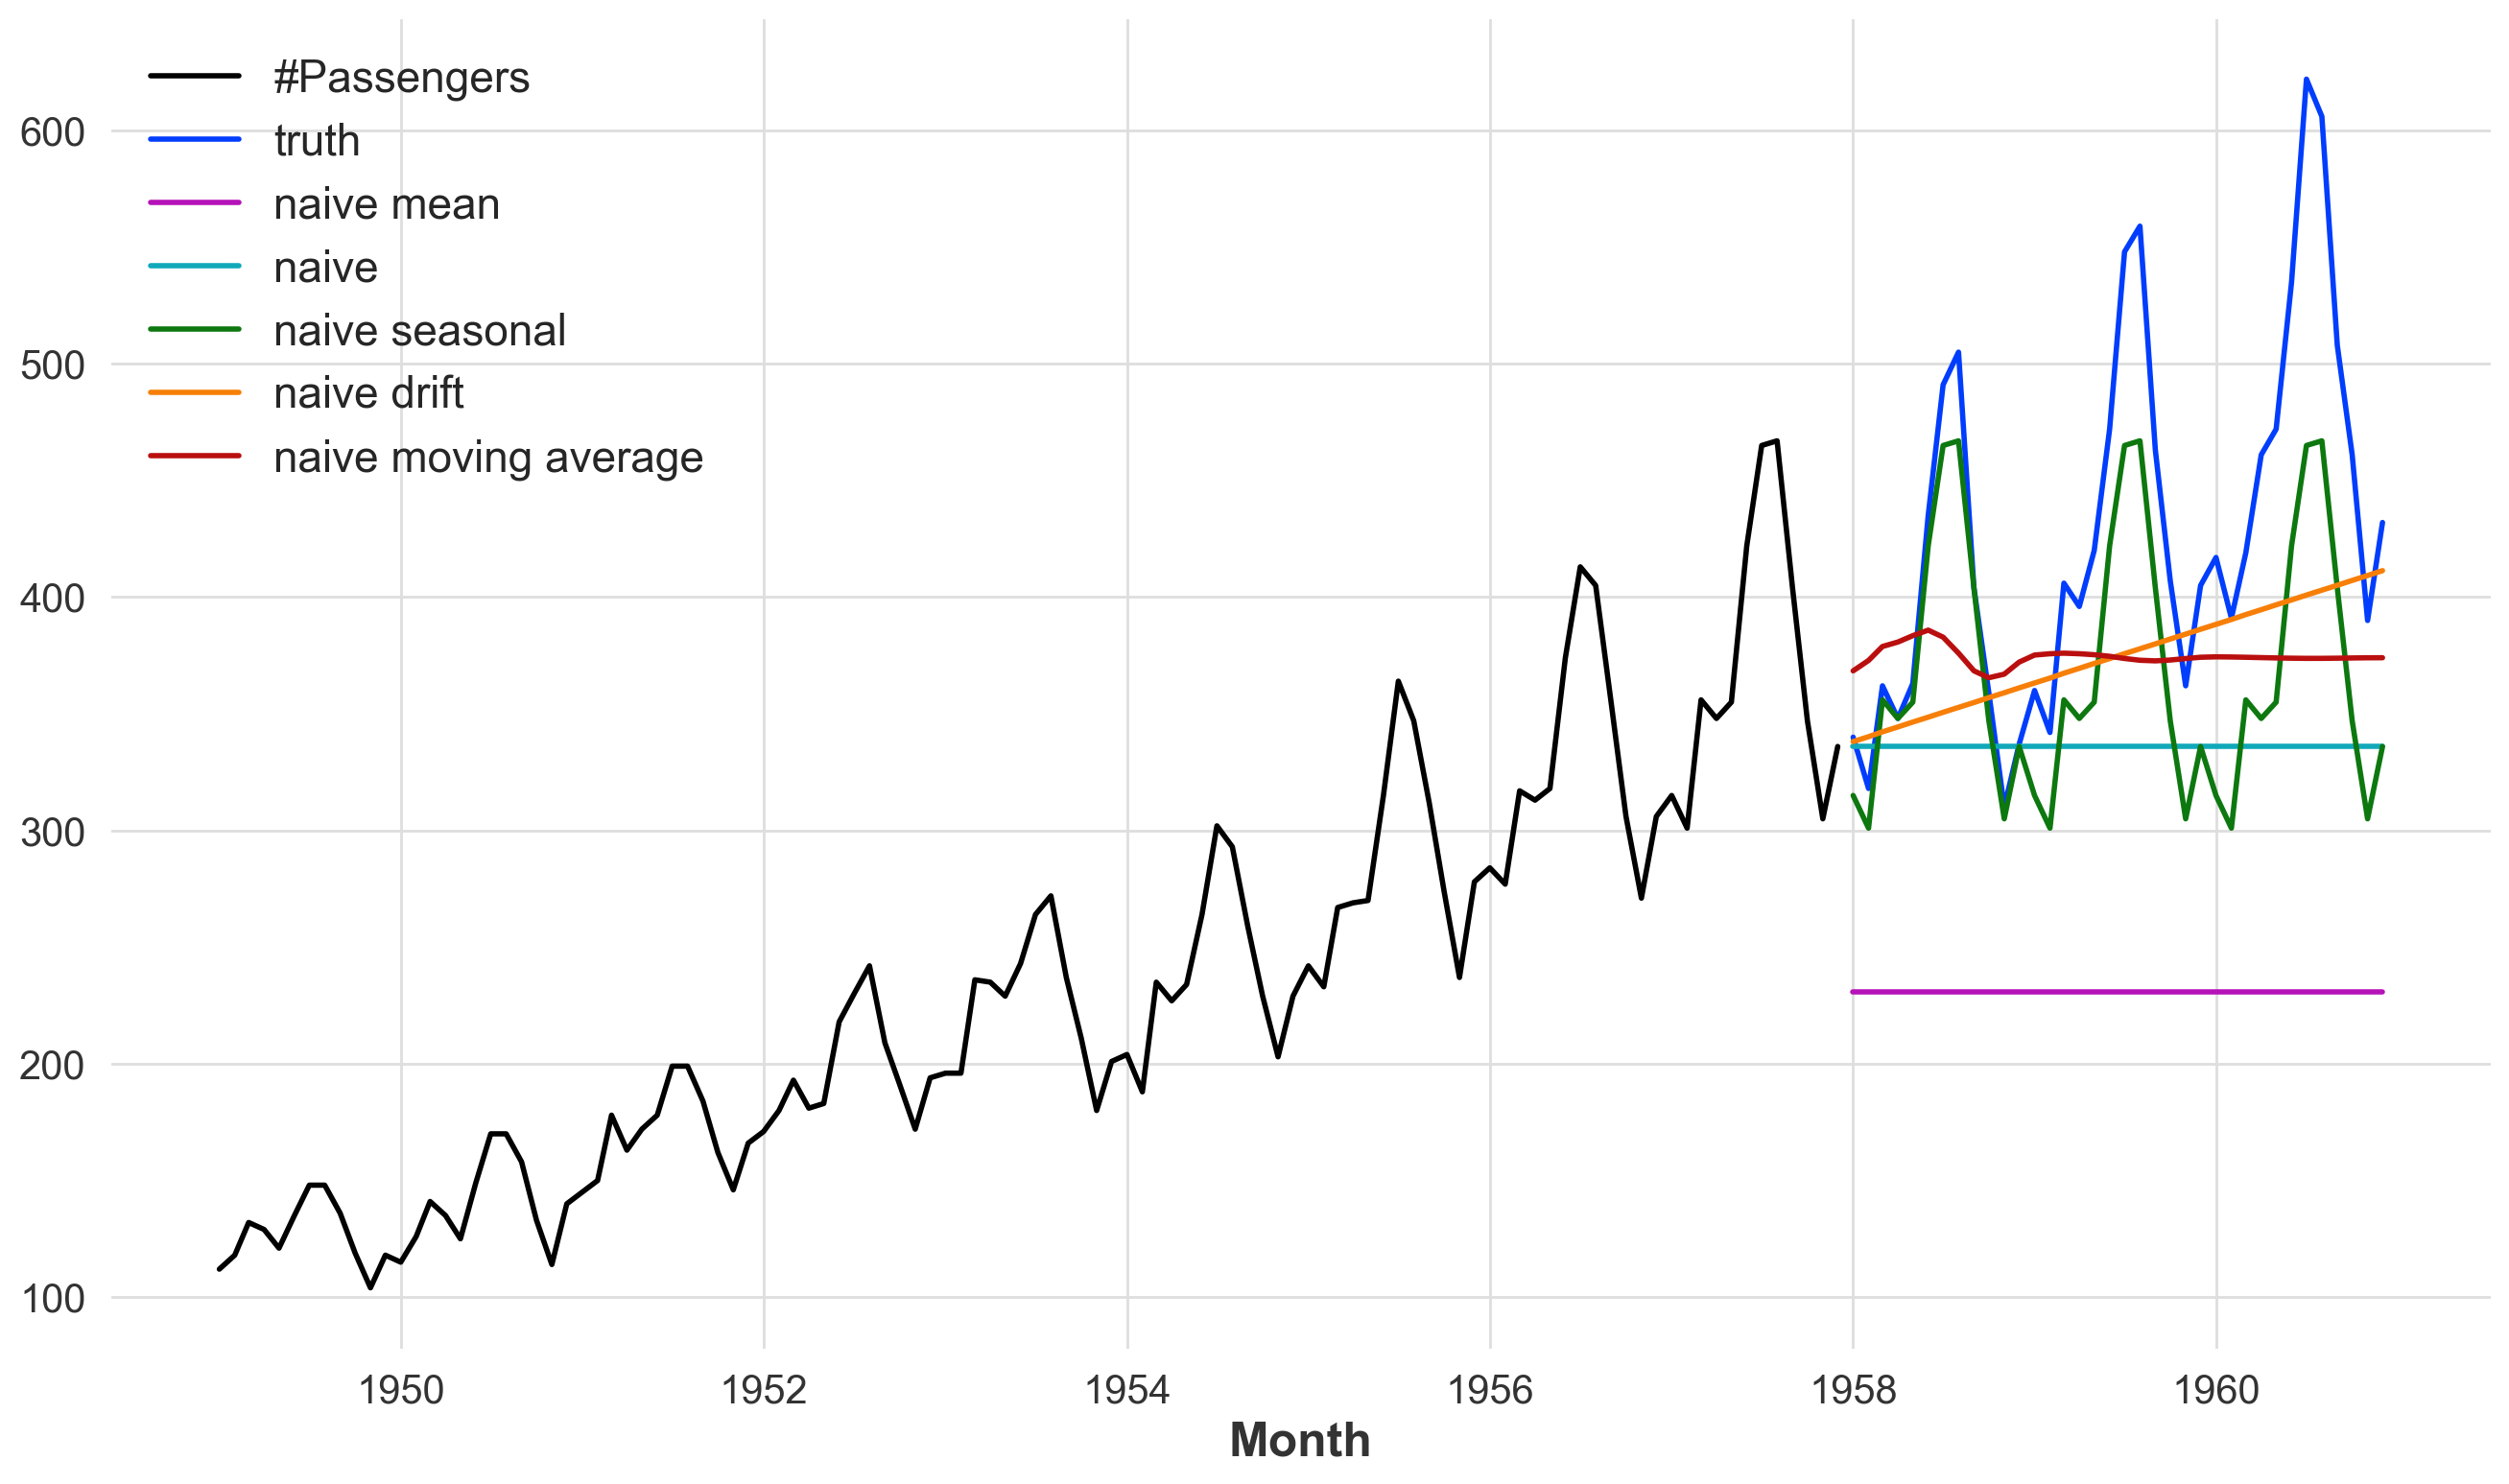

In [6]:
naive_mean_fcast = NaiveMean().fit(train).predict(len(val))
naive_fcast = NaiveSeasonal(K=1).fit(train).predict(len(val))
naive_seasonal_fcast = NaiveSeasonal(K=12).fit(train).predict(len(val))
naive_drift_fcast = NaiveDrift().fit(train).predict(len(val))
naive_ma_fcast = NaiveMovingAverage(12).fit(train).predict(len(val))

fig, ax = plt.subplots(figsize=(16,9))
train.plot(ax=ax);
val.plot(label="truth", ax=ax);
naive_mean_fcast.plot(label="naive mean", ax=ax);
naive_fcast.plot(label="naive", ax=ax);
naive_seasonal_fcast.plot(label="naive seasonal", ax=ax);
naive_drift_fcast.plot(label="naive drift", ax=ax);
naive_ma_fcast.plot(label="naive moving average", ax=ax);

## Smoothing

Smoothing is the name given to a general class of forecasting procedures that rely on a weighted sum of the past observations:
$$
    \hat{x}_{T+1} = c_0 x_T + c_1 x_{T-1} + \ldots
$$

Usually the weights are chosen such that they sum to one.

## Moving average is a smoothing

$$
  \hat{x}_{T+d} = \frac1k \sum_{t=T-k}^T x_t
$$

Moving average is smoothing with constant coefficients within a window $c_i = \frac1k$.

## Exponential smoothing

For $\alpha < 1$:
$$
\frac1\alpha = \sum_{i=1}^\infty (1 - \alpha)^i
$$

So,
$$
\sum_{i=1}^\infty \alpha (1 - \alpha)^i = 1
$$

These form the coefficients for exponential smoothing:
$$
\hat{x}_{T+1} = \alpha x_T + \alpha (1 - \alpha) x_{T-1} + \alpha (1 - \alpha)^2 x_{T-2} + \ldots
$$

## Simple exponential smoothing (Brown method)

$$
\begin{aligned}
\hat{x}_{t+1} & = l_t, \\
l_t & = \alpha x_t + (1 - \alpha) l_{t-1}
\end{aligned}
$$

- Suitable for series without trend or seasonality
- Depends on $l_0$:
  $$
    \hat{x}_{t+1} = \sum_{j=1}^{T-1} \alpha (1 - \alpha)^j x_{T-j} + (1 - \alpha)^T l_0
  $$

  We can take $l_0 = x_1$ or optimize for it

In [7]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode

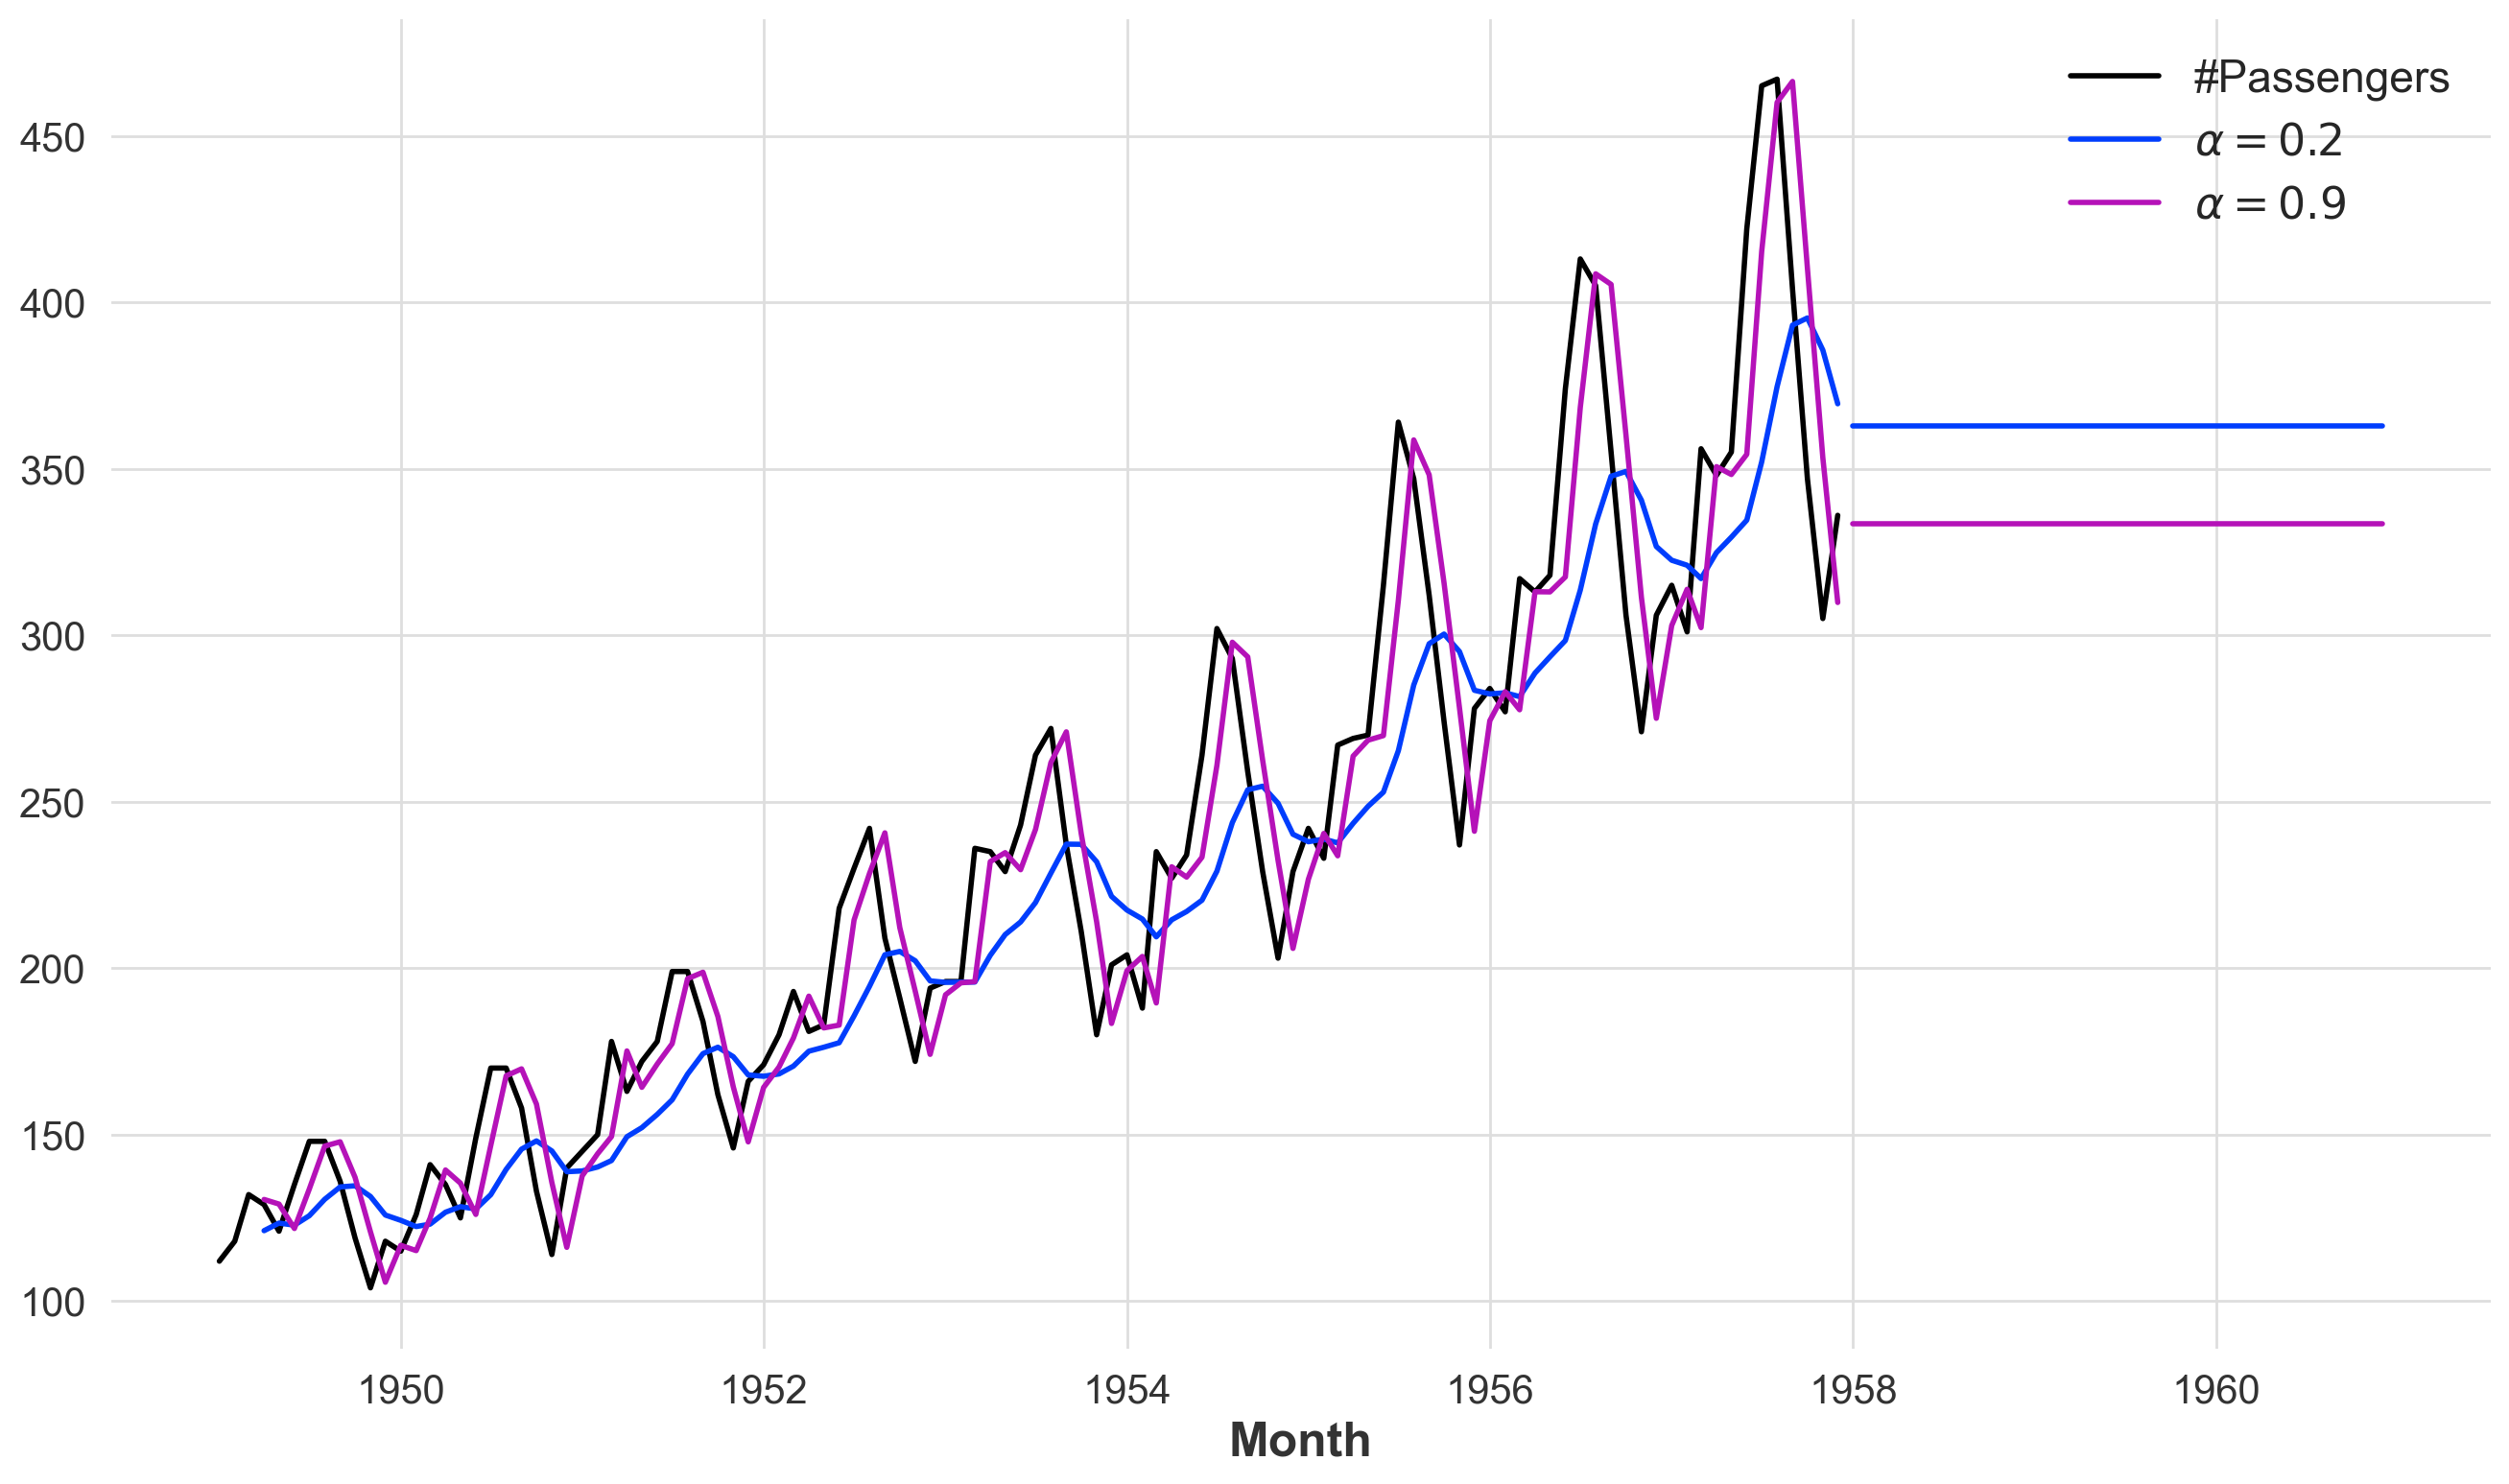

In [8]:
ses_02_bcast = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=ModelMode.NONE, smoothing_level=0.2).historical_forecasts(train)
ses_09_bcast = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=ModelMode.NONE, smoothing_level=0.9).historical_forecasts(train)

ses_02_fcast = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=ModelMode.NONE, smoothing_level=0.2).fit(train).predict(len(val))
ses_09_fcast = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=ModelMode.NONE, smoothing_level=0.9).fit(train).predict(len(val))

fig, ax = plt.subplots(figsize=(16,9))
train.plot(ax=ax);
ses_02_bcast.plot(label="$\\alpha = 0.2$", color="C1", ax=ax);
ses_09_bcast.plot(label="$\\alpha = 0.9$", color="C2", ax=ax);
ses_02_fcast.plot(label=None, color="C1", ax=ax);
ses_09_fcast.plot(label=None, color="C2", ax=ax);

## Double exponential smoothing (Holt method)

Incorporates a term for linear additive trend:
$$
\begin{aligned}
    \hat{x}_{t+d} & = l_t + d b_t, \\
    l_t & =\alpha x_t+(1-\alpha)\left(l_{t-1}+b_{t-1}\right), \\
    b_t & =\beta\left(l_t-l_{t-1}\right)+(1-\beta) b_{t-1}.
\end{aligned}
$$

## Variants of DES: multiplicative trend

$$
\begin{aligned}
    \hat{x}_{t+d} & =l_t b_t^d, \\
    l_t & =\alpha x_t+(1-\alpha)\left(l_{t-1} b_{t-1}\right), \\
    b_t & =\beta \frac{l_t}{l_{t-1}}+(1-\beta) b_{t-1}.
\end{aligned}
$$

## Variants of DES: damped trend

- Additive
    $$
    \begin{aligned}
        \hat{x}_{t+d} & = l_t + \left( \phi + \phi^2 + \ldots + \phi^d \right) b_t, \\
        l_t & =\alpha x_t+(1-\alpha)\left(l_{t-1}+\phi b_{t-1}\right), \\
        b_t & =\beta\left(l_t-l_{t-1}\right)+(1-\beta) \phi b_{t-1}.
    \end{aligned}
    $$
- Multiplcative
    $$
    \begin{aligned}
        \hat{x}_{t+d} & =l_t b_t^{\phi + \phi^2 + \ldots + \phi^d}, \\
        l_t & =\alpha x_t+(1-\alpha)\left(l_{t-1} b_{t-1}^\phi\right), \\
        b_t & =\beta \frac{l_t}{l_{t-1}}+(1-\beta) b_{t-1}^\phi.
    \end{aligned}
    $$

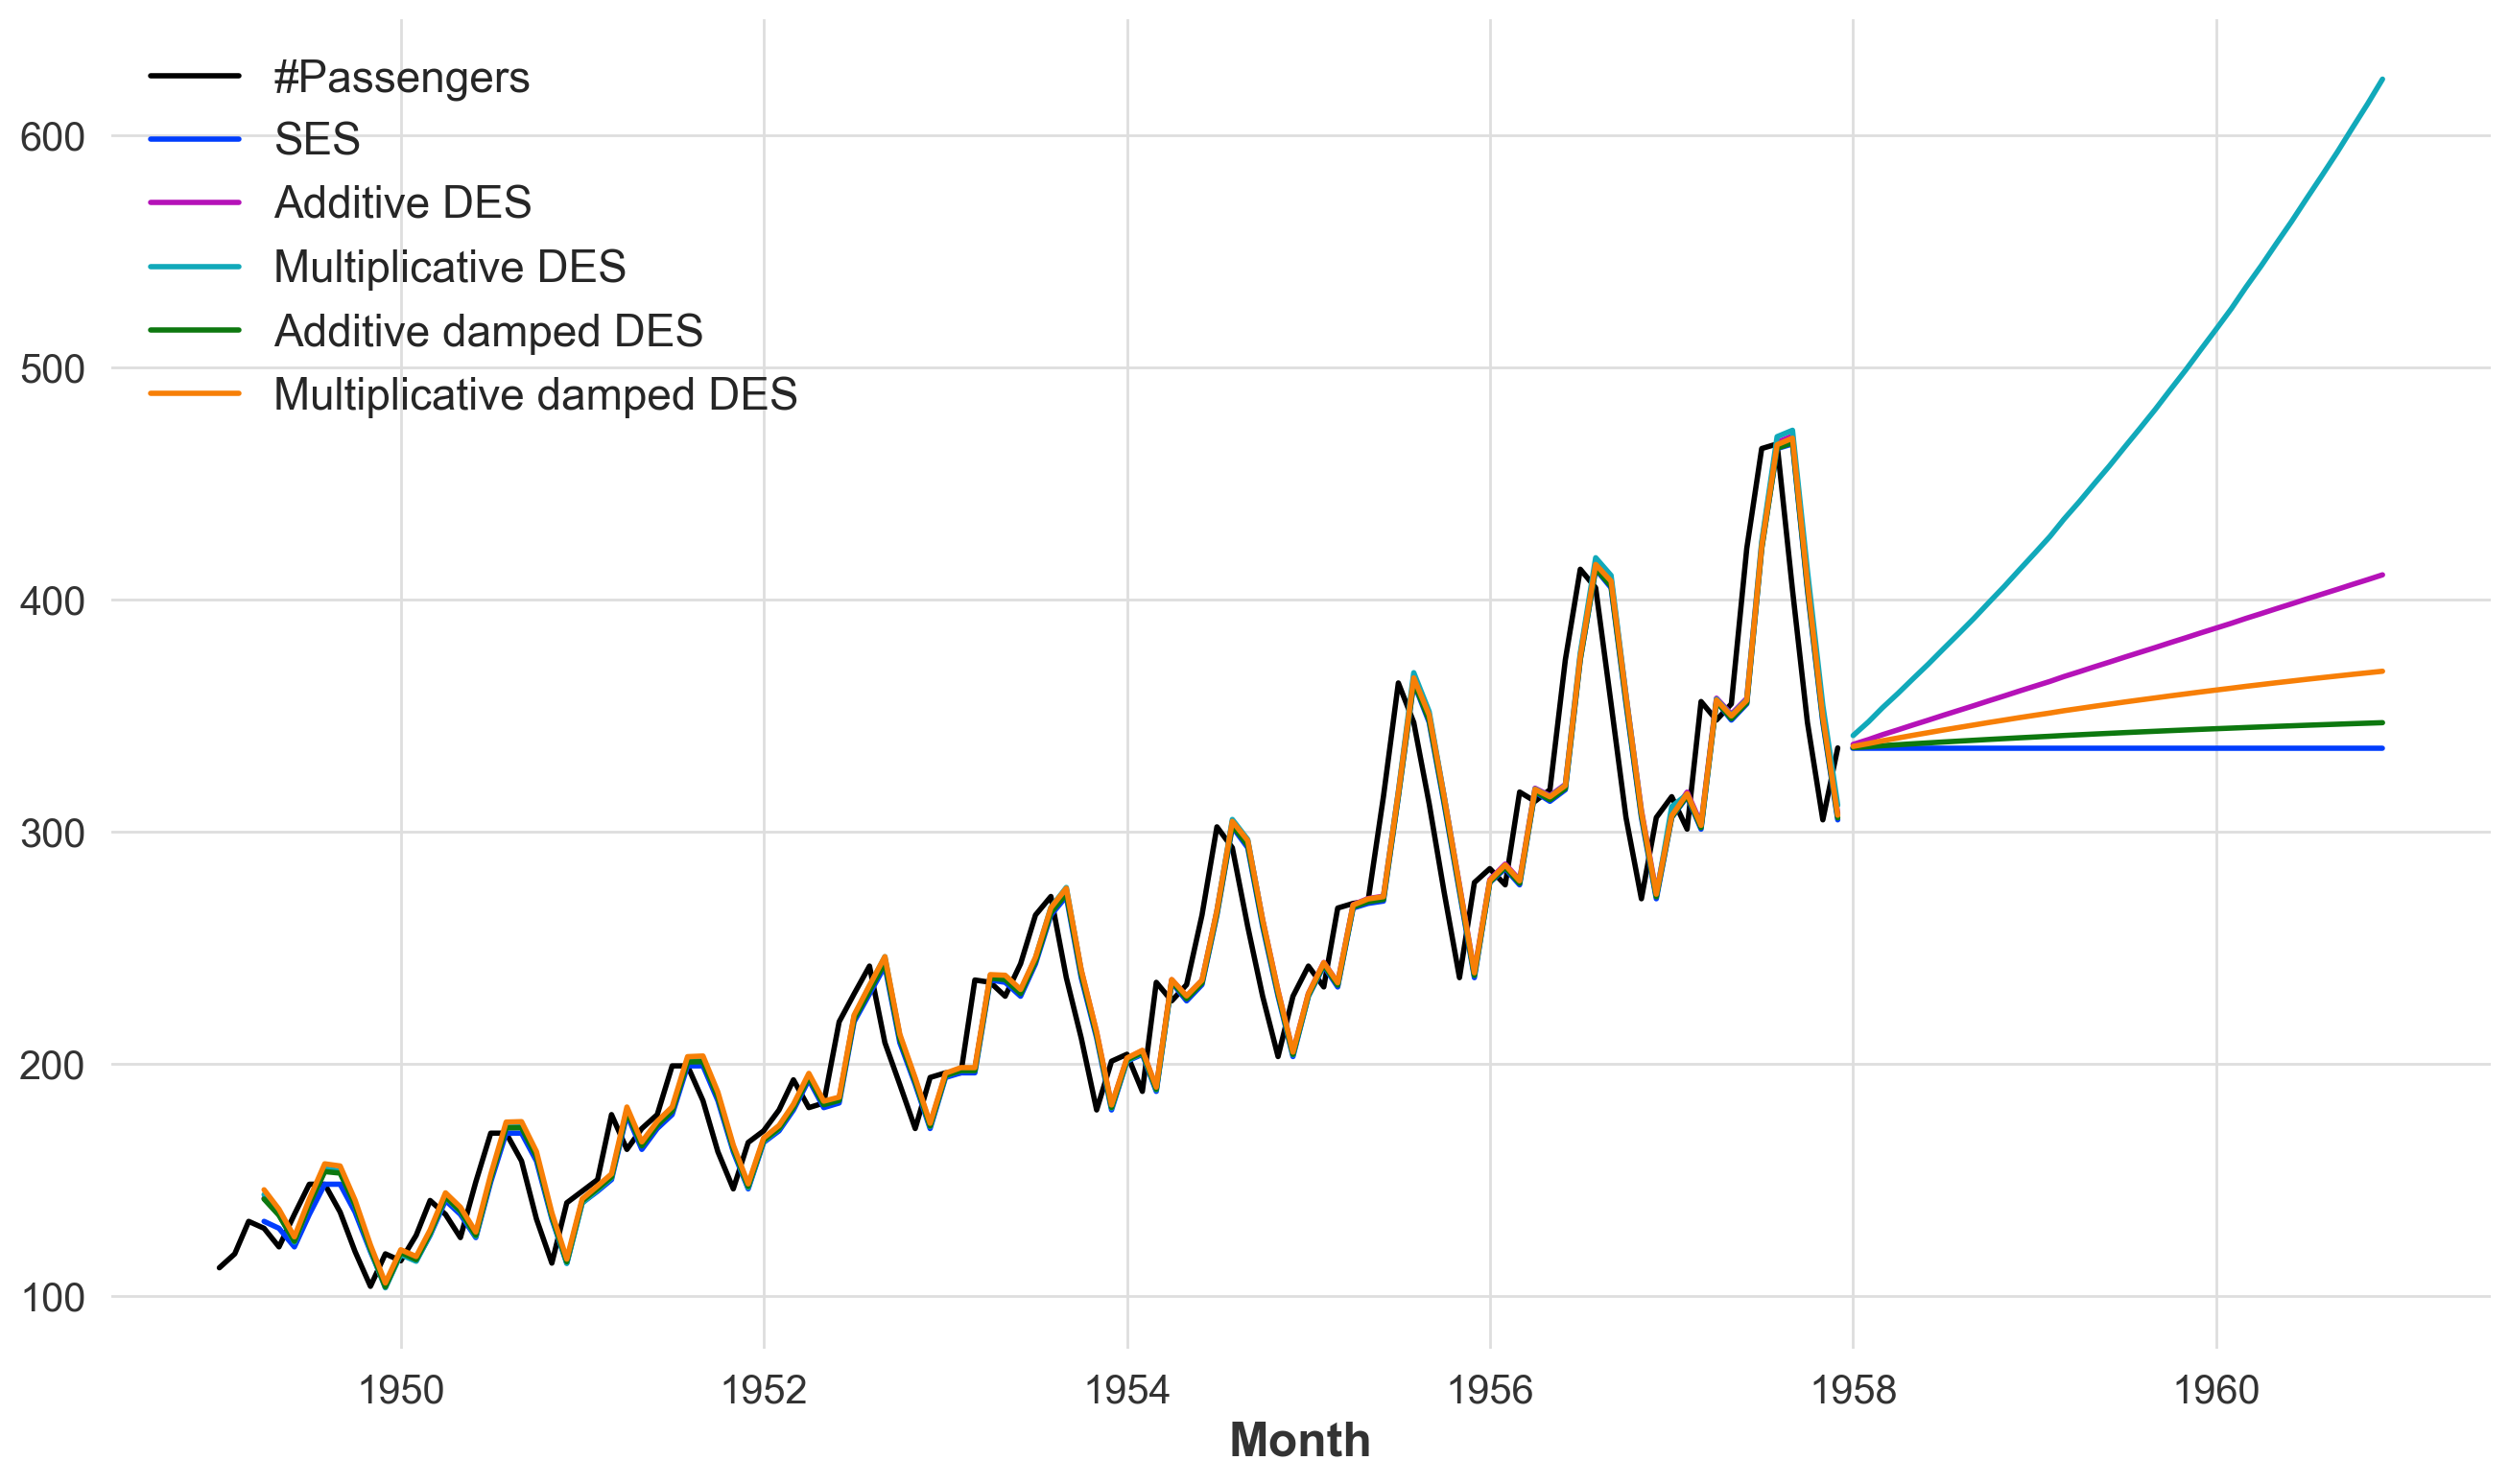

In [9]:
ses = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=ModelMode.NONE, smoothing_level=1)
bes = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=ModelMode.NONE, smoothing_level=0.98, smoothing_trend=0)
mbes = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=ModelMode.NONE, smoothing_level=0.98, smoothing_trend=0)
dbes = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=ModelMode.NONE, damped=True, smoothing_level=0.99, smoothing_trend=0, damping_trend=0.98)
dmbes = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=ModelMode.NONE, damped=True, smoothing_level=0.98, smoothing_trend=0, damping_trend=0.98)

ses_bcast = ses.historical_forecasts(train)
bes_bcast = bes.historical_forecasts(train)
mbes_bcast = mbes.historical_forecasts(train)
dbes_bcast = dbes.historical_forecasts(train)
dmbes_bcast = dmbes.historical_forecasts(train)

ses_fcast = ses.fit(train).predict(len(val))
bes_fcast = bes.fit(train).predict(len(val))
mbes_fcast = mbes.fit(train).predict(len(val))
dbes_fcast = dbes.fit(train).predict(len(val))
dmbes_fcast = dmbes.fit(train).predict(len(val))

fig, ax = plt.subplots(figsize=(16,9))
train.plot(ax=ax);
ses_bcast.plot(label="SES", color="C1", ax=ax);
bes_bcast.plot(label="Additive DES", color="C2", ax=ax);
mbes_bcast.plot(label="Multiplicative DES", color="C3", ax=ax);
dbes_bcast.plot(label="Additive damped DES", color="C4", ax=ax);
dmbes_bcast.plot(label="Multiplicative damped DES", color="C5", ax=ax);
ses_fcast.plot(label=None, color="C1", ax=ax);
bes_fcast.plot(label=None, color="C2", ax=ax);
mbes_fcast.plot(label=None, color="C3", ax=ax);
dbes_fcast.plot(label=None, color="C4", ax=ax);
dmbes_fcast.plot(label=None, color="C5", ax=ax);

## Triple exponential smoothing (Holt-Winters method)

Incorporates a term for linear additive seasonality of cycle length $m$:
$$
\begin{aligned}
\hat{x}_{t+d} & =l_t+d b_t+s_{t-m+(d \bmod m)}, \\
l_t & =\alpha\left(x_t-s_{t-m}\right)+(1-\alpha)\left(l_{t-1}+b_{t-1}\right), \\
b_t & =\beta\left(l_t-l_{t-1}\right)+(1-\beta) b_{t-1}, \\
s_t & =\gamma\left(x_t-l_{t-1}-b_{t-1}\right)+(1-\gamma) s_{t-m}.
\end{aligned}
$$

Multiplicative seasonality is also possible:
$$
\begin{aligned}
\hat{x}_{t+d \mid t} & =\left(l_t+d b_t\right) s_{t-m+(d \bmod m)}, \\
l_t & =\alpha \frac{x_t}{s_{t-m}}+(1-\alpha)\left(l_{t-1}+b_{t-1}\right), \\
b_t & =\beta\left(l_t-l_{t-1}\right)+(1-\beta) b_{t-1}, \\
s_t & =\gamma \frac{x_t}{l_{t-1}+b_{t-1}}+(1-\gamma) s_{t-m}.
\end{aligned}
$$

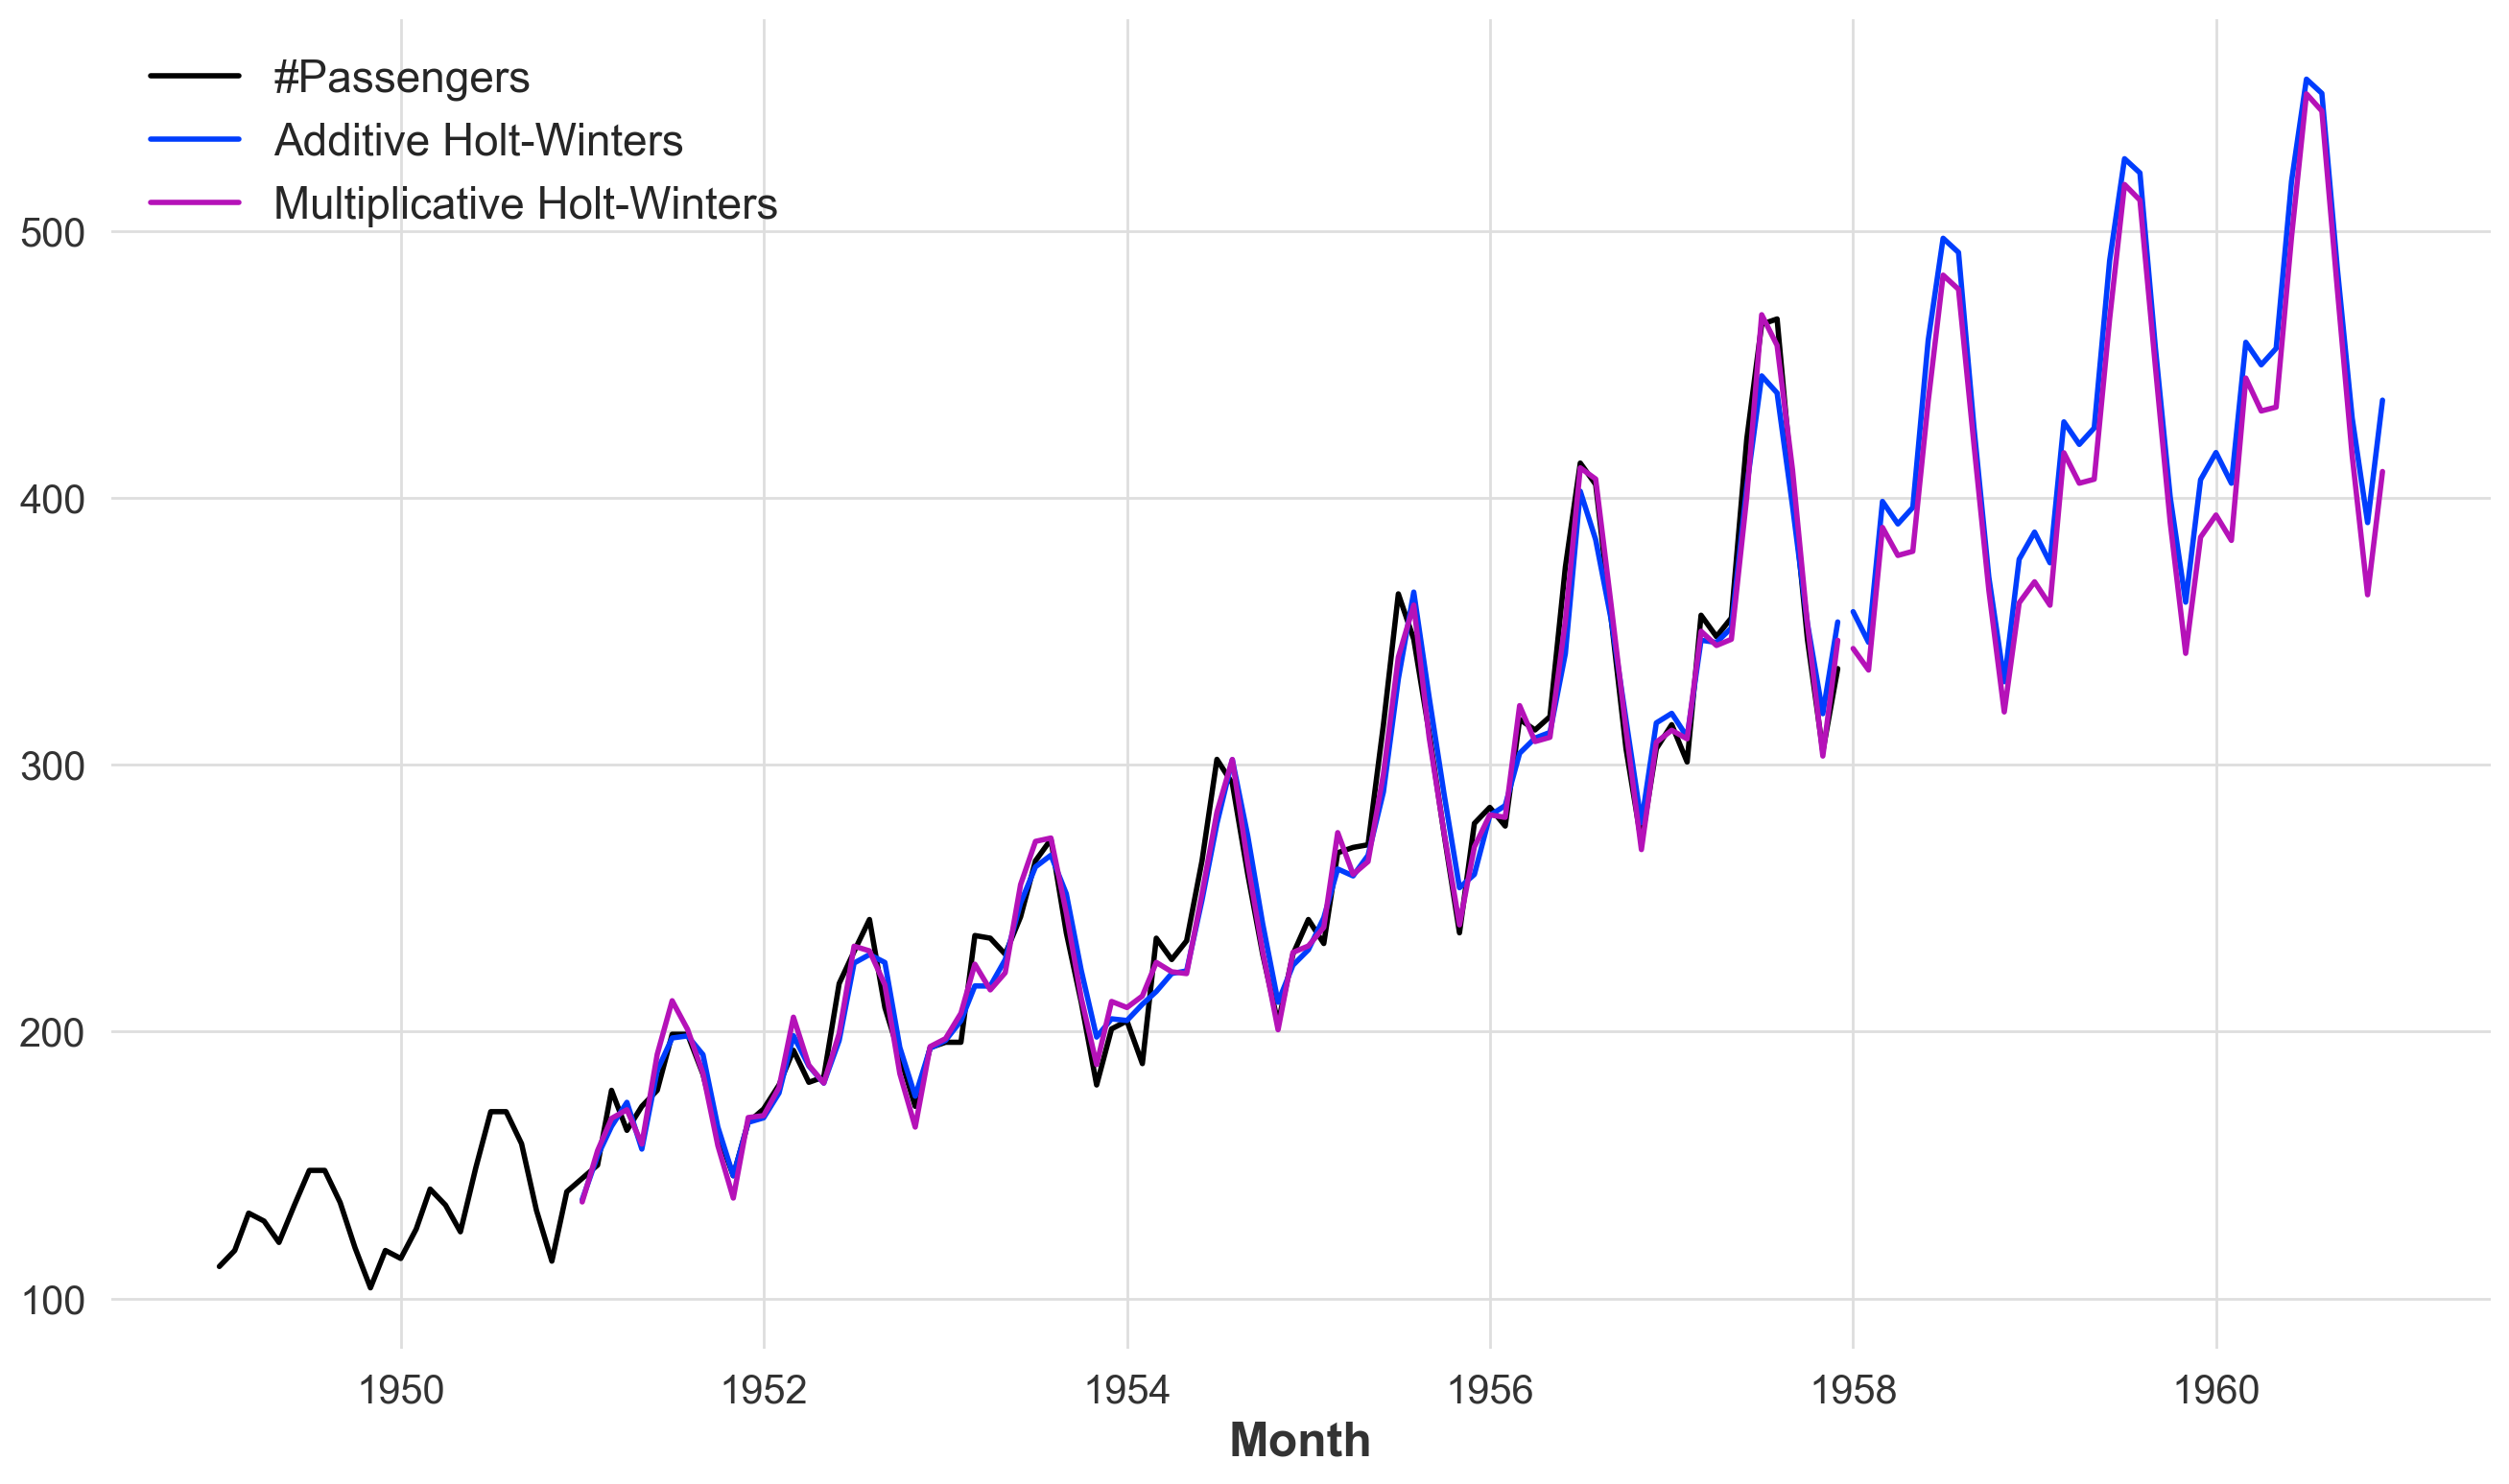

In [10]:
ets_additive = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=ModelMode.ADDITIVE, seasonal_periods=12)
ets_mult = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=ModelMode.MULTIPLICATIVE, seasonal_periods=12)

ets_additive_bcast = ets_additive.historical_forecasts(train)
ets_mult_bcast = ets_mult.historical_forecasts(train)

ets_additive_fcast = ets_additive.fit(train).predict(len(val))
ets_mult_fcast = ets_mult.fit(train).predict(len(val))

fig, ax = plt.subplots(figsize=(16,9))
train.plot(ax=ax);
ets_additive_bcast.plot(label="Additive Holt-Winters", color="C1", ax=ax);
ets_mult_bcast.plot(label="Multiplicative Holt-Winters", color="C2", ax=ax);
ets_additive_fcast.plot(label=None, color="C1", ax=ax);
ets_mult_fcast.plot(label=None, color="C2", ax=ax);

## ETS models overlook

<table>
    <thead>
        <tr>
            <th>Trend</th>
            <th rowspan=3>Seasonality</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td></td>
            <td>None</td>
            <td>Additive</td>
            <td>Multiplicative</td>
        </tr>
        <tr>
            <td>None</td>
            <td>(N, N)</td>
            <td>(N, A)</td>
            <td>(N, M)</td>
        </tr>
        <tr>
            <td>Additive</td>
            <td>(A, N)</td>
            <td>(A, A)</td>
            <td>(A, M)</td>
        </tr>
        <tr>
            <td>Additive damped</td>
            <td>(Ad, N)</td>
            <td>(Ad, A)</td>
            <td>(Ad, M)</td>
        </tr>
        <tr>
            <td>Multiplicative</td>
            <td>(M, N)</td>
            <td>(M, A)</td>
            <td>(M, M)</td>
        </tr>
        <tr>
            <td>Multiplicative damped</td>
            <td>(Md, N)</td>
            <td>(Md, A)</td>
            <td>(Md, M)</td>
        </tr>
    </tbody>
</table>

Also we can model the error as additive or multiplicative for probabilistic forecast, so we get $ETS(\cdot, \cdot, \cdot)$.

## Other models

There is a model named Theta method, which is a specific variant of exponential smoothing:
$$
\hat{x}_{t+h}=\frac{\theta-1}{\theta} \hat{b}_0\left[h-1+\frac{1}{\hat{\alpha}}-\frac{(1-\hat{\alpha})^t}{\hat{\alpha}}\right]+l_{t+h }
$$
where $b_0$ is estimated from OLS:
$$
x_t = a_0 + b_0 (t - 1) + \varepsilon_t
$$
and $\alpha$ is estimated from SES:
$$
l_t = (1 - \alpha) x_t + \alpha l_{t-1}
$$

## Prediction intervals

We have previously discussed point forecasts. Many time series models adopt probabilitstic forecasts, which express the uncertainty in forecasts with a probability distribution. It describes the probability of observing possible future values using the fitted model. The point forecast is the mean of this distribution. Most time series models produce normally distributed forecasts — that is, we assume that the distribution of possible future values follows a normal distribution.

A prediction interval gives an interval within which we expect $x_t$ to lie with a specified probability. For $h$-step forecast we can write
$$
\hat{x}_{T+h} \pm c \hat{\sigma}_h
$$
where $c$ is constant dependent on the $h$-step forecast distribution, and the probability coverage, and $\hat{\sigma}_h$ is an estimate of the standard deviation of the $h$-step forecast distribution.

## Prediction intervals from residuals under normality assumption

Under normality assumption $c$ equals a certain percentile of Normal distribution, e.g. for $95\%$ interval:
$$
\hat{x}_{T+h} \pm 1.96 \hat{\sigma}_h
$$

An estimate of standard deviation of the forecast distribution $\hat{\sigma}_h$ is necessary in order to compute the prediction interval, and can be estimated from the standard deviation of the residuals.

Such intervals tend to be too narrow, because only the variation in the errors is accounted for. There is also variation in the parameter estimates, and in the model order, that has not been included in the calculation. In addition, the calculation assumes that the historical patterns that have been modelled will continue into the forecast period.

## Prediction intervals from bootstrapped residuals

When a normal distribution for the residuals is an unreasonable assumption, one alternative is to use bootstrapping, which only assumes that the residuals are uncorrelated with constant variance.

We generate future steps and assign them errors sampled from training data. Then we compute prediction intervals by calculating percentiles of the future sample paths for each forecast horizon. The result is called a bootstrapped prediction interval.

## One-step prediction intervals

As stated previously estimate of standard deviation of the forecast distribution $\hat{\sigma}_h$ can be obtained from the standard deviation of the residuals. For one-step ahead forecast, it is given by
$$
\hat{\sigma} = \sqrt{\frac{1}{T - K - M} \sum_{t=1}^T e_t^2}
$$

## Multi-step prediction intervals

For multi-step prediction forecast, the calculation depends on the model, and the calculation is generally more involved. We can for example give closed form mathematical expressions of multi-step prediction intervals for naïve models.

## Prediction intervals of benchmark methods

- Mean
  $$
   \hat{\sigma}_h = \hat{\sigma} \sqrt{1 + \frac1T} 
  $$
- Naïve
  $$
    \hat{\sigma}_h = \hat{\sigma} \sqrt{h}
  $$
- Seasonal naïve
  $$
    \hat{\sigma}_h = \hat{\sigma} \sqrt{k + 1}
  $$
- Naïve drift
  $$
    \hat{\sigma}_h = \hat{\sigma} \sqrt{h \left( 1 + \frac{h}{T+1}\right)}
  $$

In [16]:
from astsadata import jj

In [17]:
jj = TimeSeries.from_series(jj.set_index(
    pd.date_range(
        jj.index[0].start_time.date(),
        periods=len(jj),
        freq="Q-DEC",
        inclusive="both"
    )
))

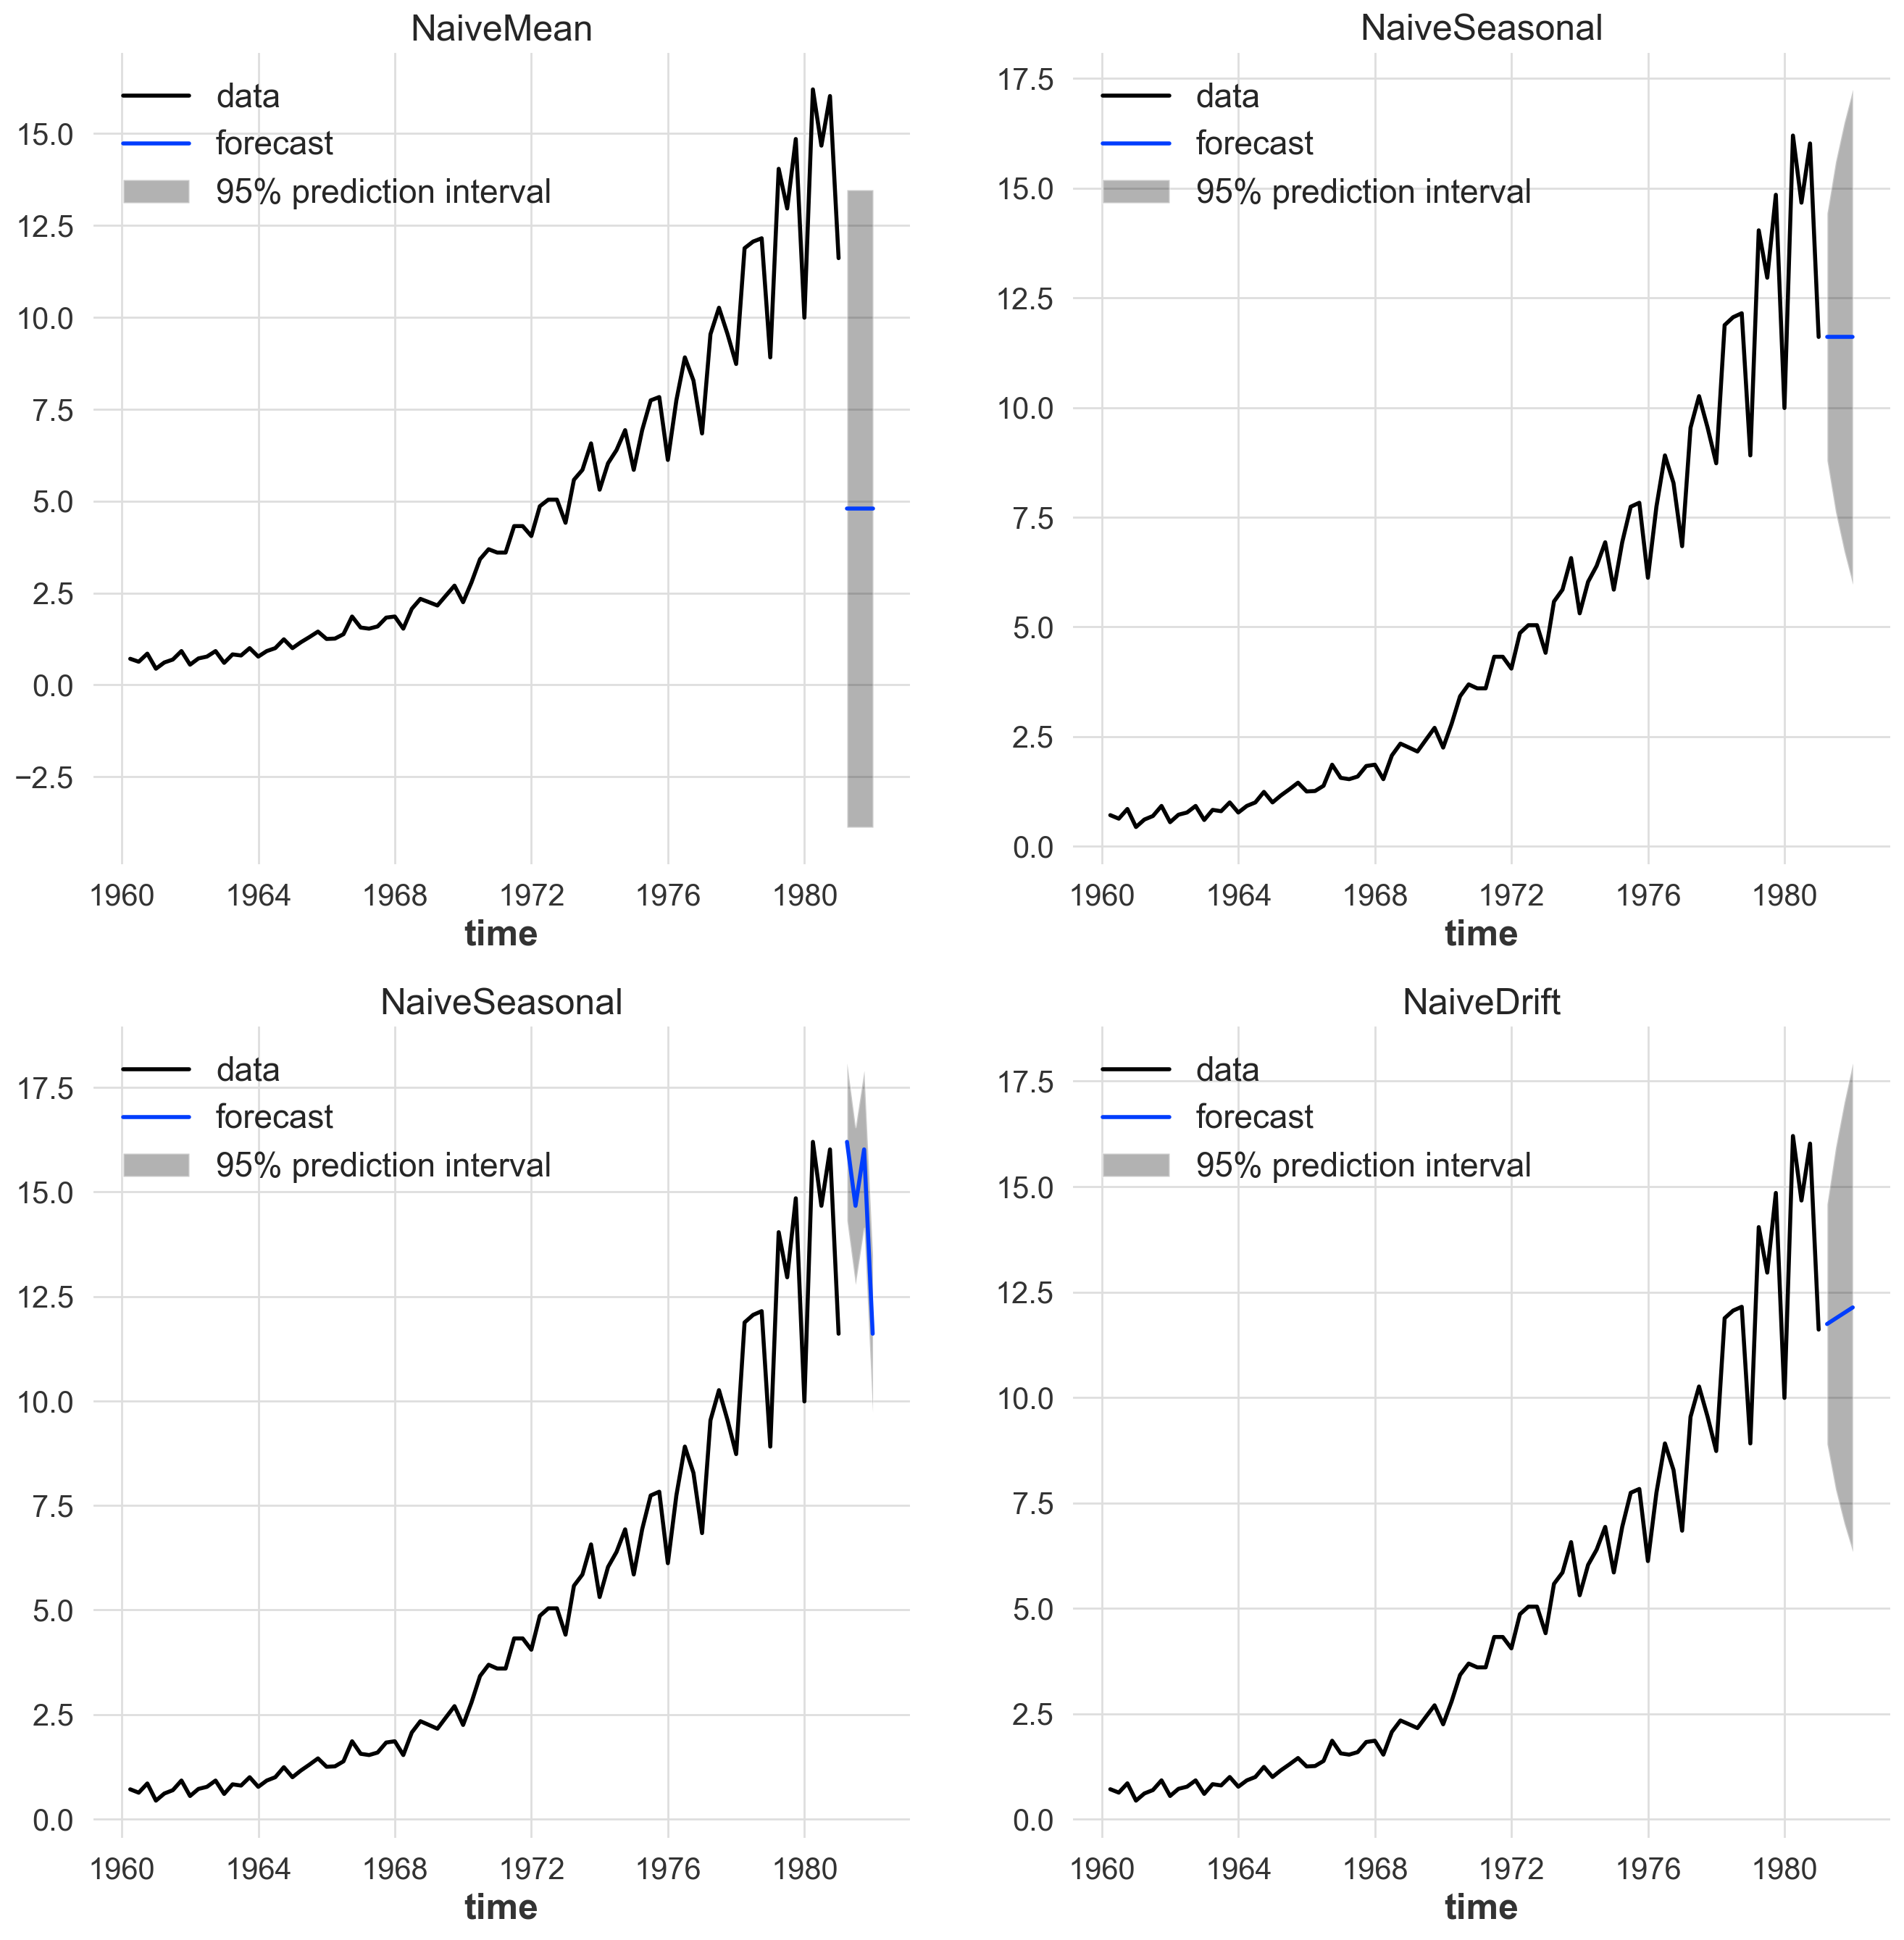

In [20]:
# example of interval forecast
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (model, ax) in enumerate(
    zip(
        [
            NaiveMean(),
            NaiveSeasonal(K=1),
            NaiveSeasonal(K=4),
            NaiveDrift(),
        ],
        axes.flatten()
    )
):
    jj.plot(ax=ax, label="data");
    model.fit(jj);
    resid = model.residuals(jj)
    sigma_hat = np.sqrt((resid.values() ** 2).sum() / len(resid))
    if i == 0:
        sigma_hat_hs = [sigma_hat * np.sqrt(1 + 1 / len(resid))] * 4
    elif i == 1:
        sigma_hat_hs = [sigma_hat * np.sqrt(h) for h in range(1, 5)]
    elif i == 2:
        sigma_hat_hs = [sigma_hat * np.sqrt(np.floor((h - 1) / 4) + 1) for h in range(1, 5)]
    elif i == 3:
        sigma_hat_hs = [sigma_hat * np.sqrt(h * (1 + h / (len(resid) + 1))) for h in range(1, 5)]
    fcast = model.predict(4)
    fcast.plot(ax=ax, label="forecast");
    lbs = [y - 1.96 * s for y, s in zip(fcast.values().flatten(), sigma_hat_hs)]
    ubs = [y + 1.96 * s for y, s in zip(fcast.values().flatten(), sigma_hat_hs)]
    ax.fill_between(fcast.pd_series().index, lbs, ubs, alpha=0.3, label="95% prediction interval")
    ax.set_title(model.__class__.__name__)
    ax.legend();

## Prediction intervals of some ETS models

For ETS models, formulas for $\hat{\sigma}_h^2$ can be complicated. Here are the formulas for the additive ETS models, which are the simplest:
- $(A, N, N)$
  $$
    \sigma_h^2=\sigma^2\left[1+\alpha^2(h-1)\right]
  $$
- $(A, A, N)$
  $$
    \sigma_h^2=\sigma^2\left[1+(h-1)\left\{\alpha^2+\alpha \beta h+\frac{1}{6} \beta^2 h(2 h-1)\right\}\right]
  $$
- $(A, A_d, N)$
  $$
    \begin{aligned}
    \sigma_h^2=\sigma^2[ & 1+\alpha^2(h-1)+\frac{\beta \phi h}{(1-\phi)^2}\{2 \alpha(1-\phi)+\beta \phi\} \\
    & \left.-\frac{\beta \phi\left(1-\phi^h\right)}{(1-\phi)^2\left(1-\phi^2\right)}\left\{2 \alpha\left(1-\phi^2\right)+\beta \phi\left(1+2 \phi-\phi^h\right)\right\}\right]
    \end{aligned}
  $$

## Prediction intervals of some ETS models

- $(A, N, A)$
  $$
    \sigma_h^2=\sigma^2\left[1+\alpha^2(h-1)+\gamma k(2 \alpha+\gamma)\right]
  $$
- $(A, A, A)$
  $$
    \begin{gathered}
    \sigma_h^2=\sigma^2\left[1+(h-1)\left\{\alpha^2+\alpha \beta h+\frac{1}{6} \beta^2 h(2 h-1)\right\}\right. \\
    +\left.\gamma k\{2 \alpha+\gamma+\beta m(k+1)\}\right]
    \end{gathered}
  $$
- $(A, A_d, A)$
  $$
    \begin{aligned}
    \sigma_h^2=\sigma^2[ & 1+\alpha^2(h-1)+\gamma k(2 \alpha+\gamma) \\
    & +\frac{\beta \phi h}{(1-\phi)^2}\{2 \alpha(1-\phi)+\beta \phi\} \\
    & -\frac{\beta \phi\left(1-\phi^h\right)}{(1-\phi)^2\left(1-\phi^2\right)}\left\{2 \alpha\left(1-\phi^2\right)+\beta \phi\left(1+2 \phi-\phi^h\right)\right\} \\
    & \left.+\frac{2 \beta \gamma \phi}{(1-\phi)\left(1-\phi^m\right)}\left\{k\left(1-\phi^m\right)-\phi^m\left(1-\phi^{m k}\right)\right\}\right]
    \end{aligned}
  $$

In [21]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode

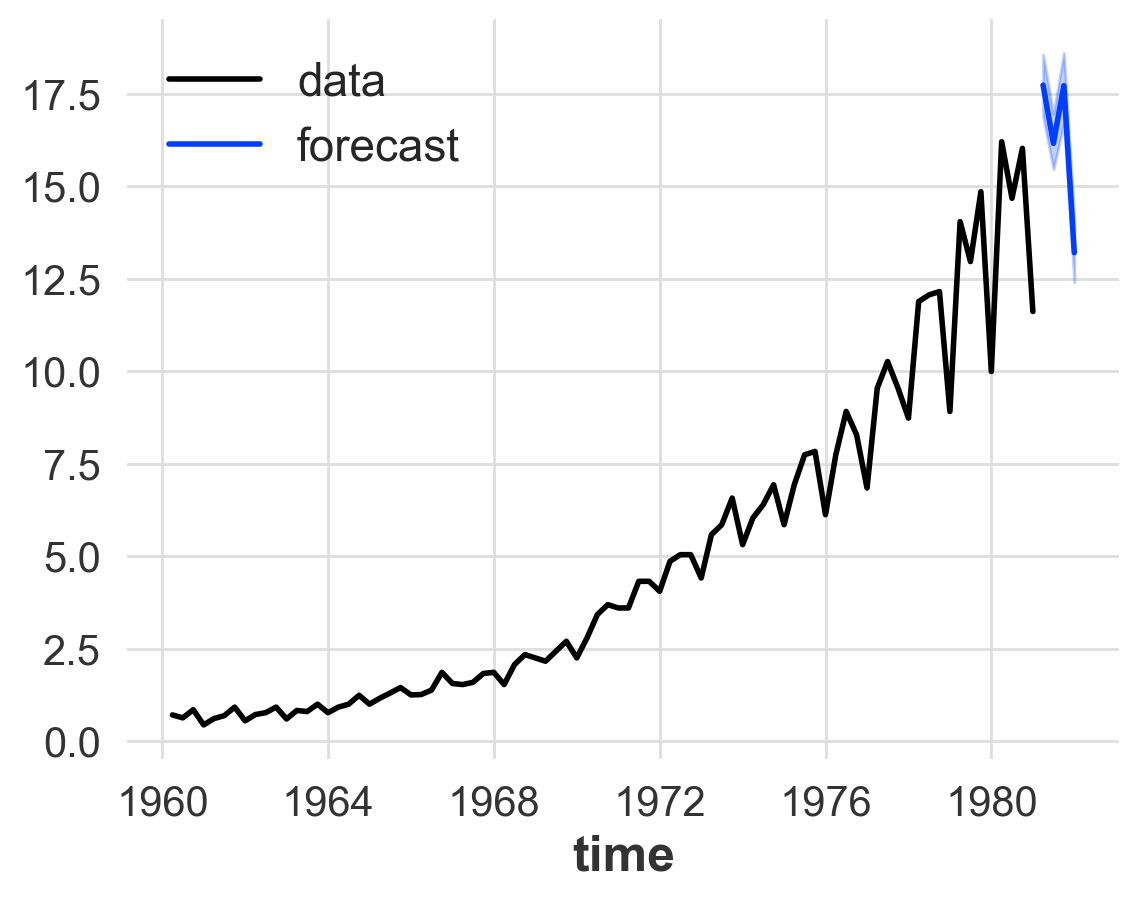

In [22]:
ets = ExponentialSmoothing()
ets.fit(jj)
fcast = ets.predict(4, num_samples=50)
fig, ax = plt.subplots()
jj.plot(ax=ax, label="data")
fcast.plot(ax=ax, label="forecast");

## Prediction intervals of some ARIMA models

The calculation of ARIMA prediction intervals is even more difficult than for ETS. It is easy to obtain in the following particular cases:
- MA model $ARIMA(0, 0, q)$, which admits the following reformulation:
  $$
    x_t=\varepsilon_t+\sum_{i=1}^q \theta_i \varepsilon_{t-i}
  $$
  has the following forecast standard deviation:
  $$
    \hat{\sigma}_h^2=\hat{\sigma}^2\left[1+\sum_{i=1}^{h-1} \hat{\theta}_i^2\right]
  $$
- We showed that an $AR(1)$ model can be written as an $MA(\infty)$ model. Using this equivalence, the above result for $MA(q)$ models can also be used to obtain prediction intervals for $AR(1)$ models.

In [23]:
from darts.models import StatsForecastAutoARIMA as AutoARIMA

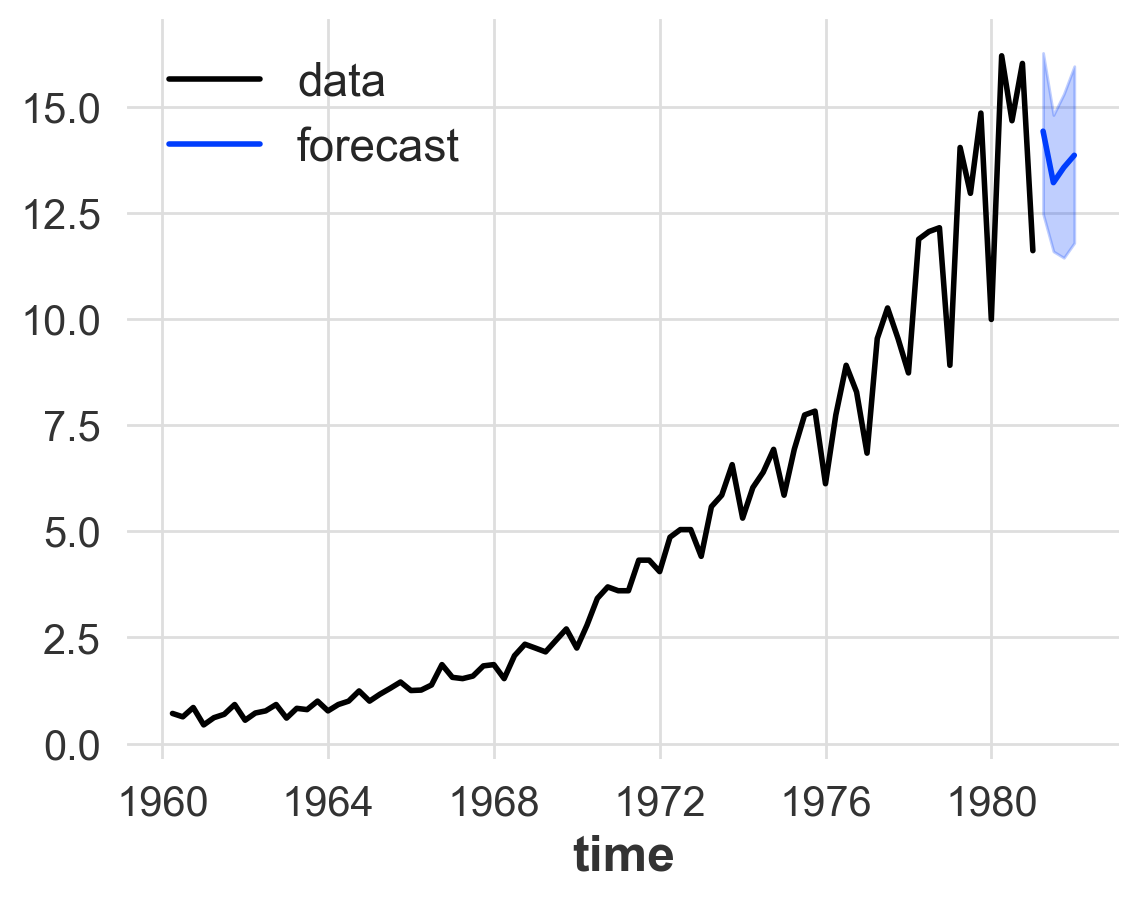

In [24]:
arima = AutoARIMA()
arima.fit(jj)
fcast = arima.predict(4, num_samples=50)
fig, ax = plt.subplots()
jj.plot(ax=ax, label="data")
fcast.plot(ax=ax, label="forecast");

## Modeling changes in variance

Previously, we assumed and event tested homoscedacity. However, we are sometimes concerned with modelling changes in variance. Such models do not generally lead to better point forecasts, but may lead to better estimates of the (local) variance. This, in turn, allows more reliable prediction intervals to be computed.

Suppose we have a time series from which
- any trend and seasonal effects have been removed
- linear (short-term correlation) effects may also have been removed

We denote this derived series by $Y_t$, to distinguish it from the original observed series, $X_t$. Examples of $Y_t$:
- residuals from a regression or AR model.
- returns: first differences of a financial time series such as the natural log of a share price
  $$
    Y_t = \nabla \log X_t = \frac{X_t - X_{t-1}}{X_{t-1}}
  $$

A random walk model is often used as a first approximation for $X_t$ so that the first differences $Y_t$ are white noise. However, the variance of such a series is often modeled as time-varying, and turns out to be stongly correlated.]

## Autoregressive conditionally heteroscedastic (ARCH) model

The simplest ARCH model $ARCH(1)$:
$$
\begin{aligned}
y_t & =\sigma_t \epsilon_t \\
\sigma_t^2 & =\alpha_0+\alpha_1 y_{t-1}^2
\end{aligned}
$$

As with ARMA models, we must impose some constraints on the model parameters to obtain desirable properties. In order to do it nicely, let's establish a connection between ARCH and ARMA processes.

## ARCH(1) properties + estimation

It is possible to write the $ARCH(1)$ model as a non-Gaussian $AR(1)$ model in the square of the returns $y_t^2$:
$$
y_t^2 = \alpha_0 + \alpha_1 y_{t-1}^2 + v_t
$$
where $v_t = \sigma_t^2 (\epsilon_t^2 - 1)$

Properties:
- If $0 \leqslant \alpha_1 < 1$, then $y_t$ is white noise
- If additionally $3 \alpha_1^2 < 1$, then $y_t^2$ follows $AR(1)$ process
- If $3 \alpha_1 < 1$ and $\alpha_1 < 1$, then such AR process is strictly stationary

The estimation of ARCH model is similar to previous estimations we've studied, and is done with conditional maximum likelihood.

## ARCH(m)

It is trivial to extend $ARCH(1)$ to $ARCH(m)$:
$$
\begin{aligned}
y_t & =\sigma_t \epsilon_t \\
\sigma_t^2 & =\alpha_0+\alpha_1 y_{t-1}^2 + \alpha_2 y_{t-2}^2 + \ldots + \alpha_m y_{t-m}^2
\end{aligned}
$$

## Generalized ARCH (GARCH) model

Another extension to ARCH is generalized ARCH, which allows the volatility to be auto-regressive as well. E.g. $GARCH(1, 1)$:
$$
\begin{aligned}
y_t & =\sigma_t \epsilon_t \\
\sigma_t^2 & =\alpha_0+\alpha_1 y_{t-1}^2 + \beta_1 \sigma_{t-1}^2
\end{aligned}
$$

## GARCH(1, 1) properties + estimation

Similarly to $ARCH(1)$, we can rewrite $GARCH(1, 1)$ as ARMA process under $\alpha_1 + \beta_1 < 1$:
$$
y_t^2 = \alpha_0 + (\alpha_1 + \beta_1) y_{t-1}^2 + v_t - \beta_1 v_{t-1}
$$

Estimation is done using conditional maximum likelihood.

## GARCH(m, r)

$$
\begin{aligned}
y_t & =\sigma_t \epsilon_t \\
\sigma_t^2 & =\alpha_0+\sum_{j=1}^m\alpha_j y_{t-j}^2 + \sum_{j=1}^r\beta_j \sigma_{t-j}^2
\end{aligned}
$$

In [25]:
from arch import arch_model

In [50]:
from astsadata import eqexp

In [51]:
exp6 = TimeSeries.from_series(eqexp["EX6"])
exp6 = exp6[0:70].map(lambda ts, x: x + 10)

In [52]:
returns = (exp6.diff(n=1) / exp6[:-1])

<Axes: xlabel='time'>

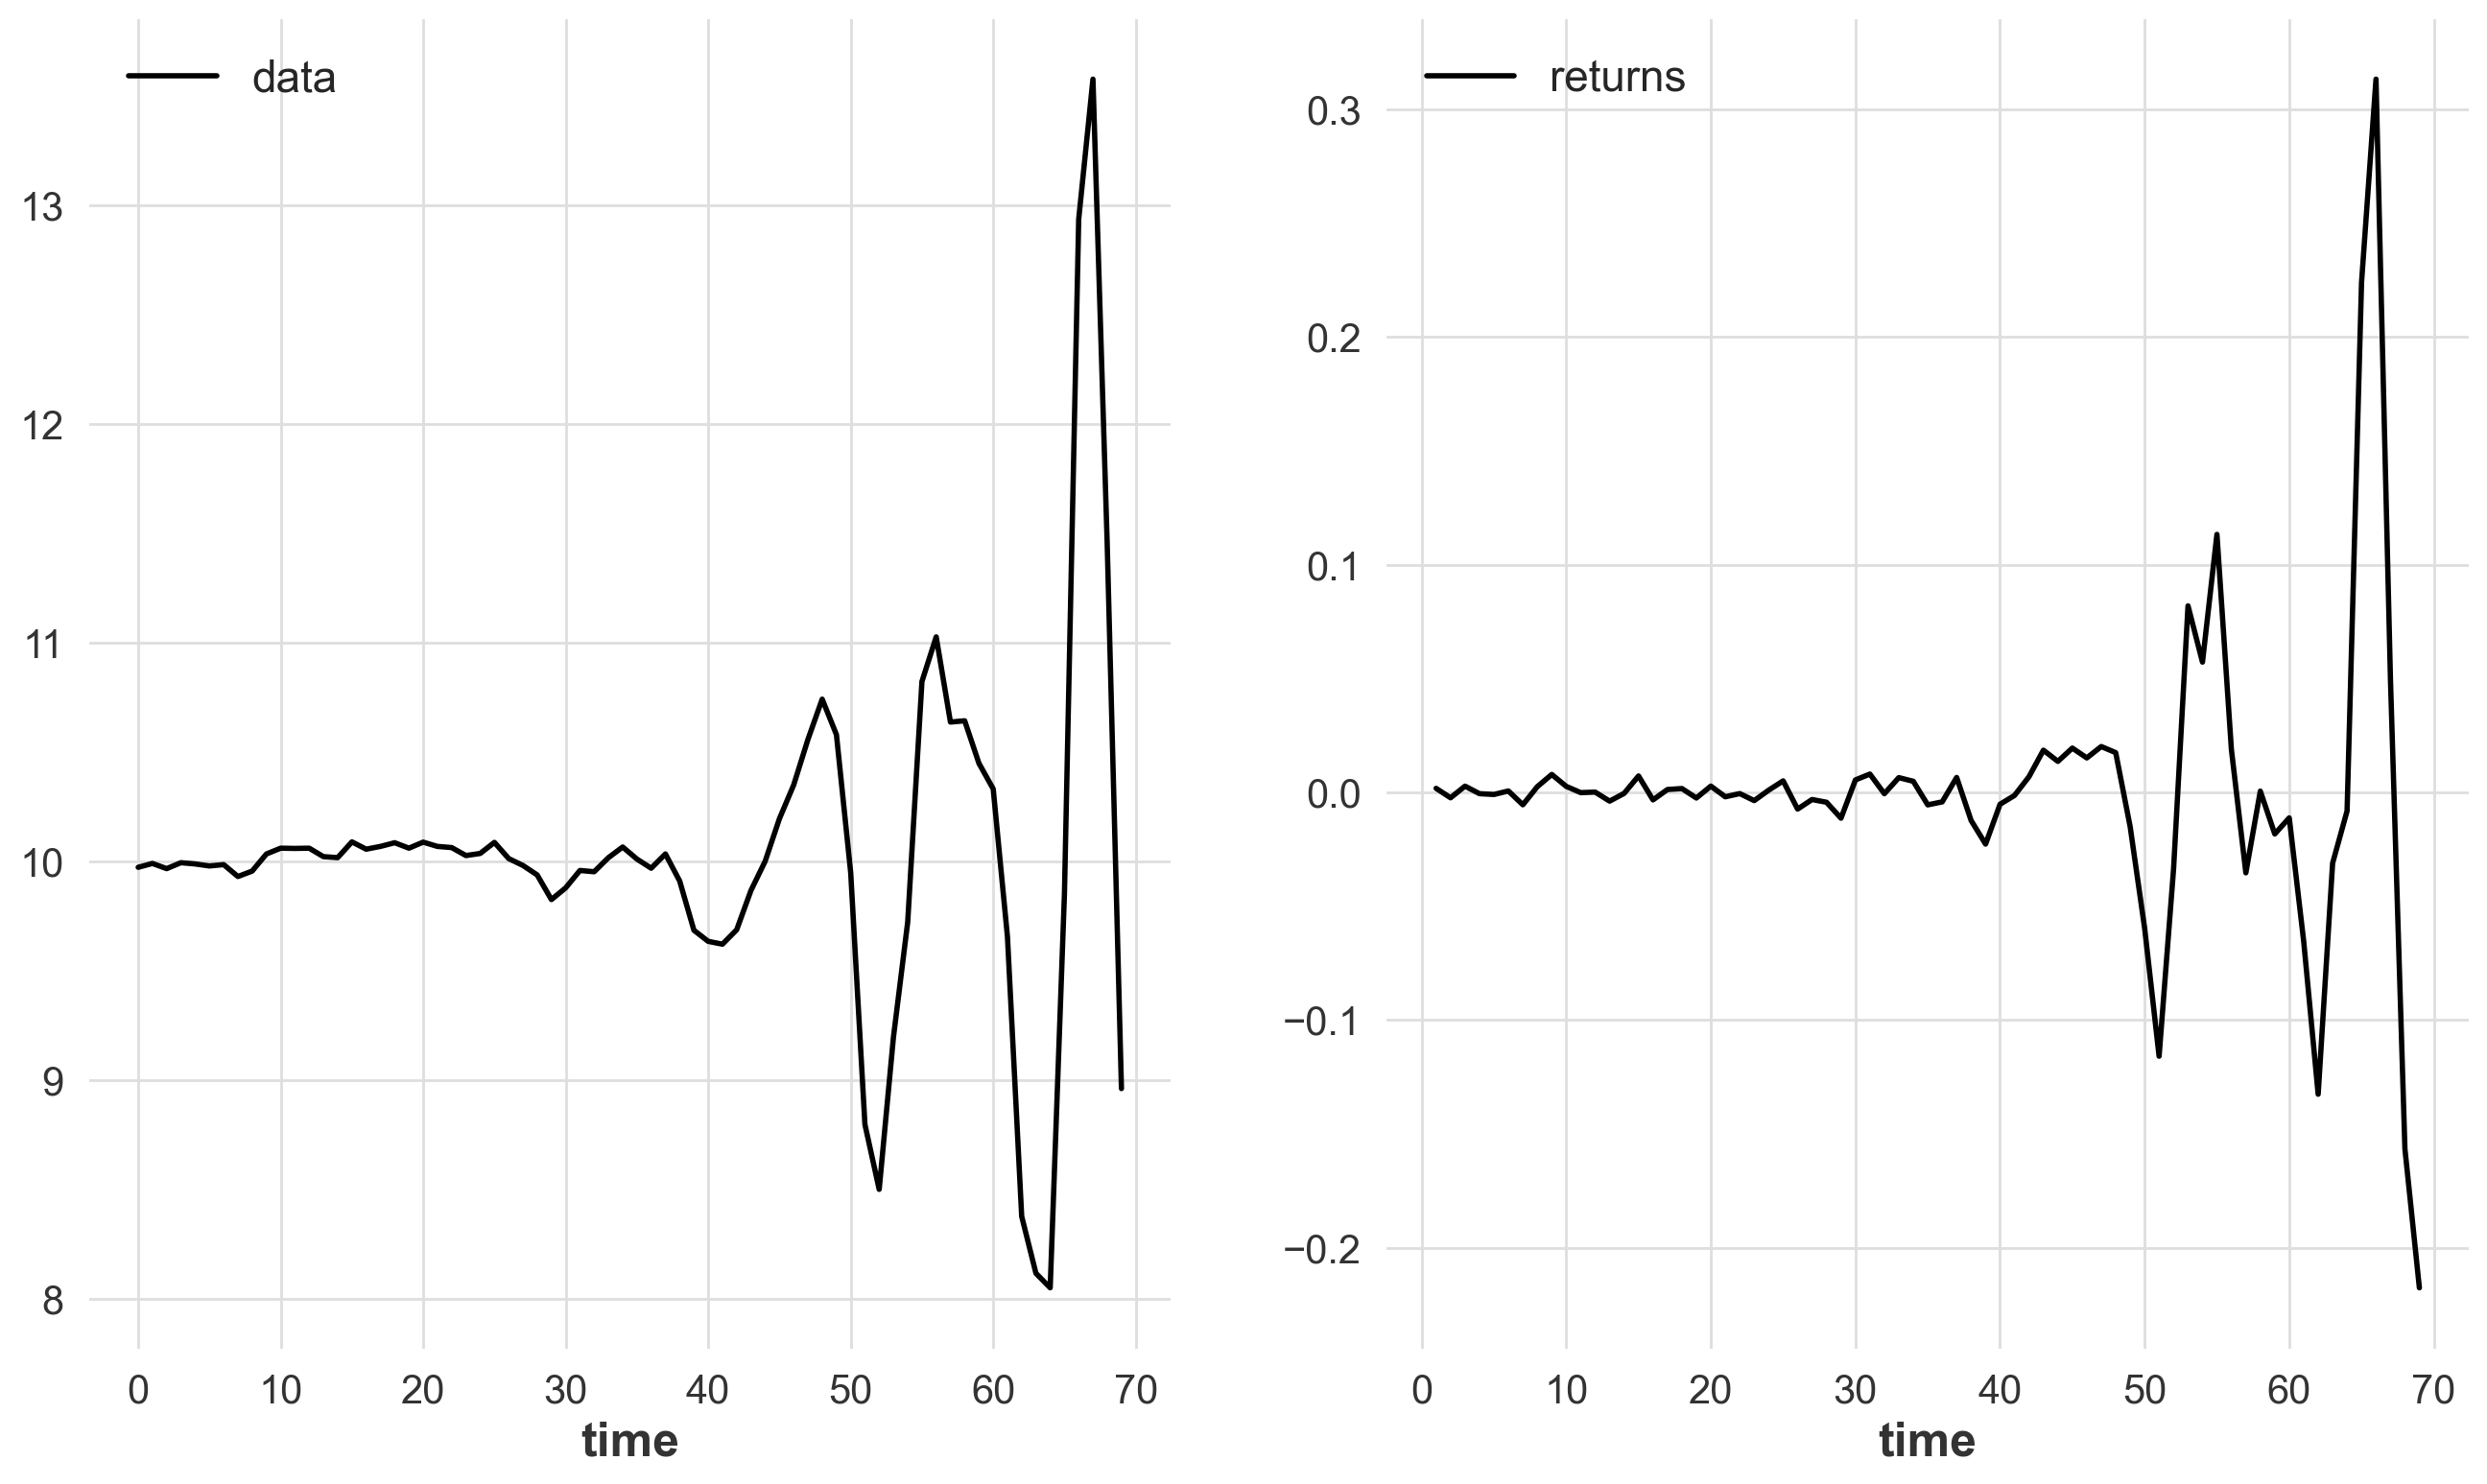

In [53]:
fig, ax = plt.subplots(1,2,figsize=(16,9))
exp6.plot(ax=ax[0], label="data")
returns.plot(ax=ax[1], label="returns")

In [54]:
returns = returns.values().flatten()

In [55]:
garch = arch_model(returns, p=1, q=1, rescale=False)
garch_fitted = garch.fit()
garch_forecast = garch_fitted.forecast(horizon=100)

Iteration:      1,   Func. Count:      5,   Neg. LLF: -148.46330696307564
Optimization terminated successfully    (Exit mode 0)
            Current function value: -148.46330729426734
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


In [56]:
fcast = garch_forecast.mean.values[0]
sigma_hat_hs = np.sqrt(garch_forecast.variance.values[0])

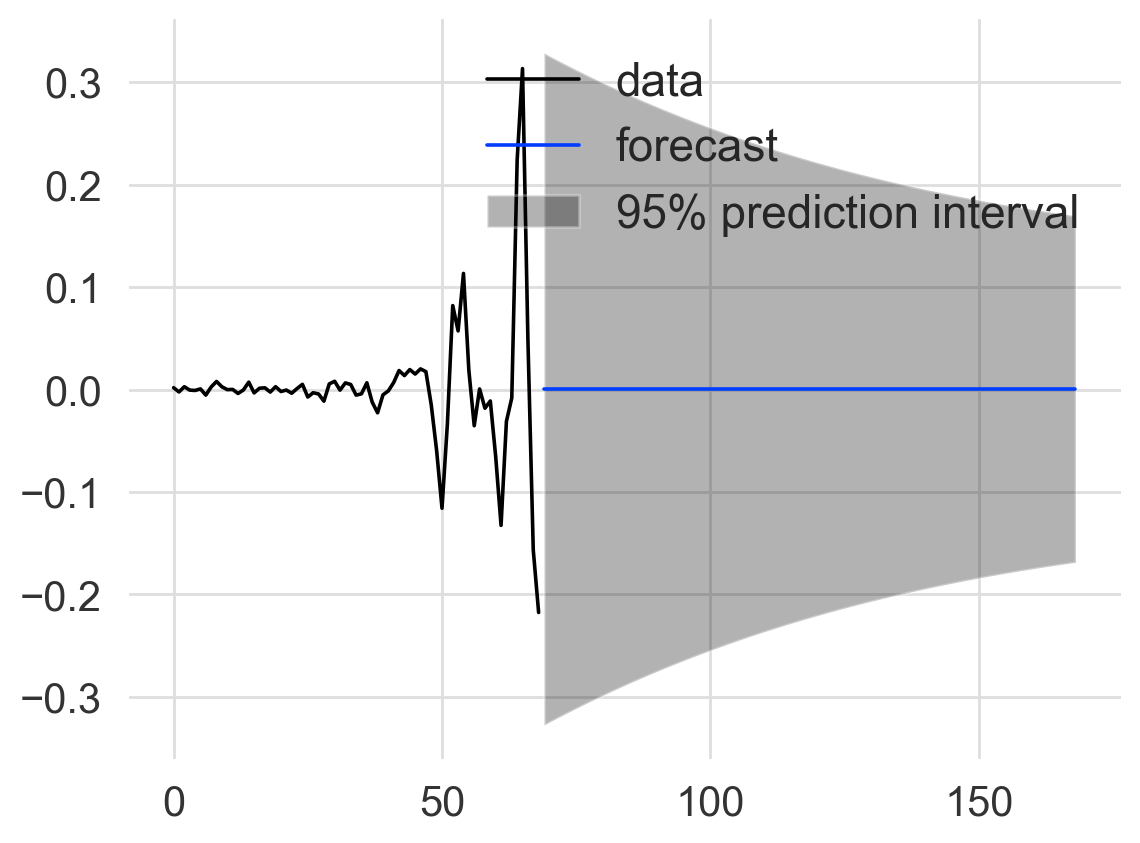

In [57]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(returns)), returns, label="data")
ax.plot(np.arange(len(returns), len(returns)+100), fcast, label="forecast");
lbs = [y - 1.96 * s for y, s in zip(fcast, sigma_hat_hs)]
ubs = [y + 1.96 * s for y, s in zip(fcast, sigma_hat_hs)]
ax.fill_between(np.arange(len(returns), len(returns)+100), lbs, ubs, alpha=0.3, label="95% prediction interval")
ax.legend();

# Webinar

## STL decomposition

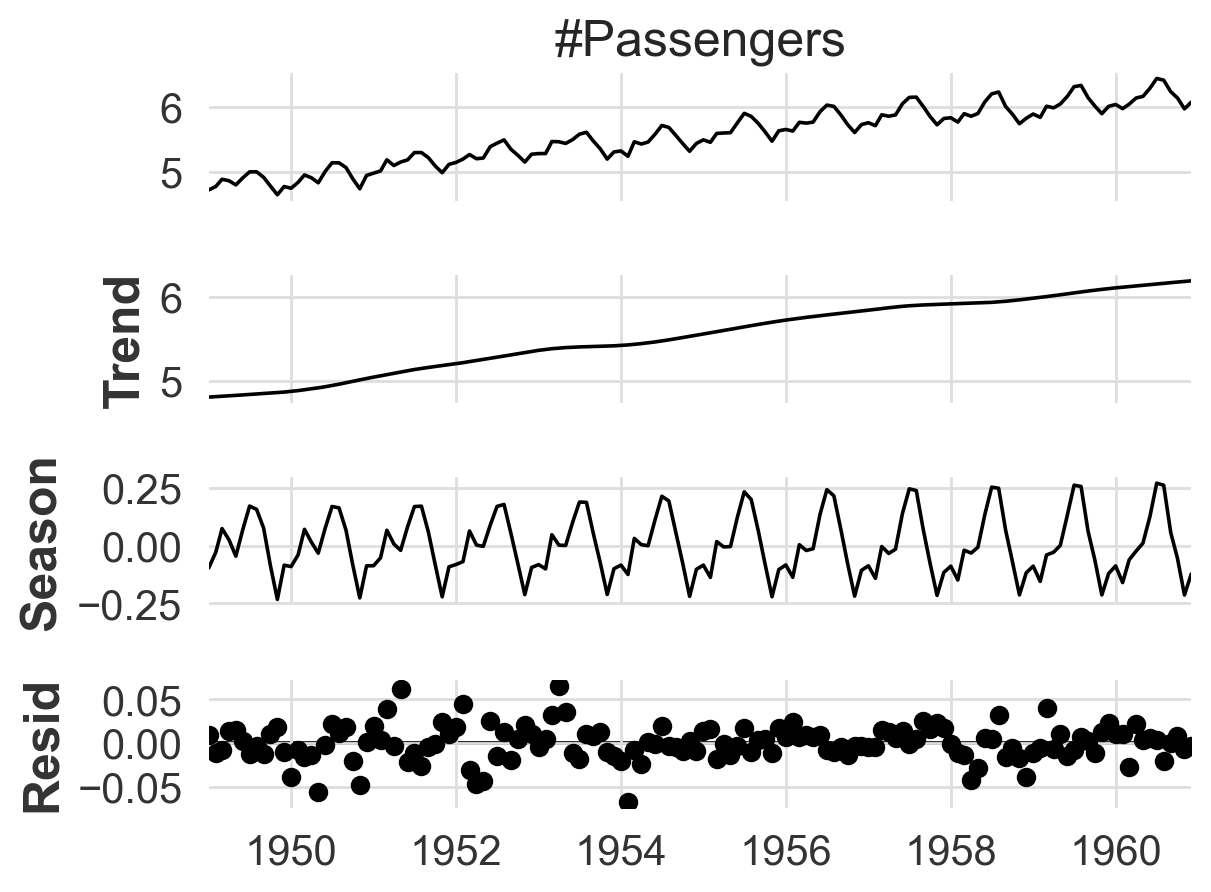

In [58]:
tsa.STL(air_pax.map(lambda ts,s x: np.log(x)).pd_dataframe().iloc[:, 0]).fit().plot();

In [59]:
model = tsa.STLForecast(train.map(lambda ts, x: np.log(x)).pd_dataframe().iloc[:, 0], tsa.ARIMA, model_kwargs=dict(order=(2, 1, 1), trend="t"))
fitted_model = model.fit()
fcast = TimeSeries.from_dataframe(fitted_model.forecast(len(val)).to_frame())

/Users/nstulov/miniconda3/envs/msai/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nstulov/miniconda3/envs/msai/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nstulov/miniconda3/envs/msai/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


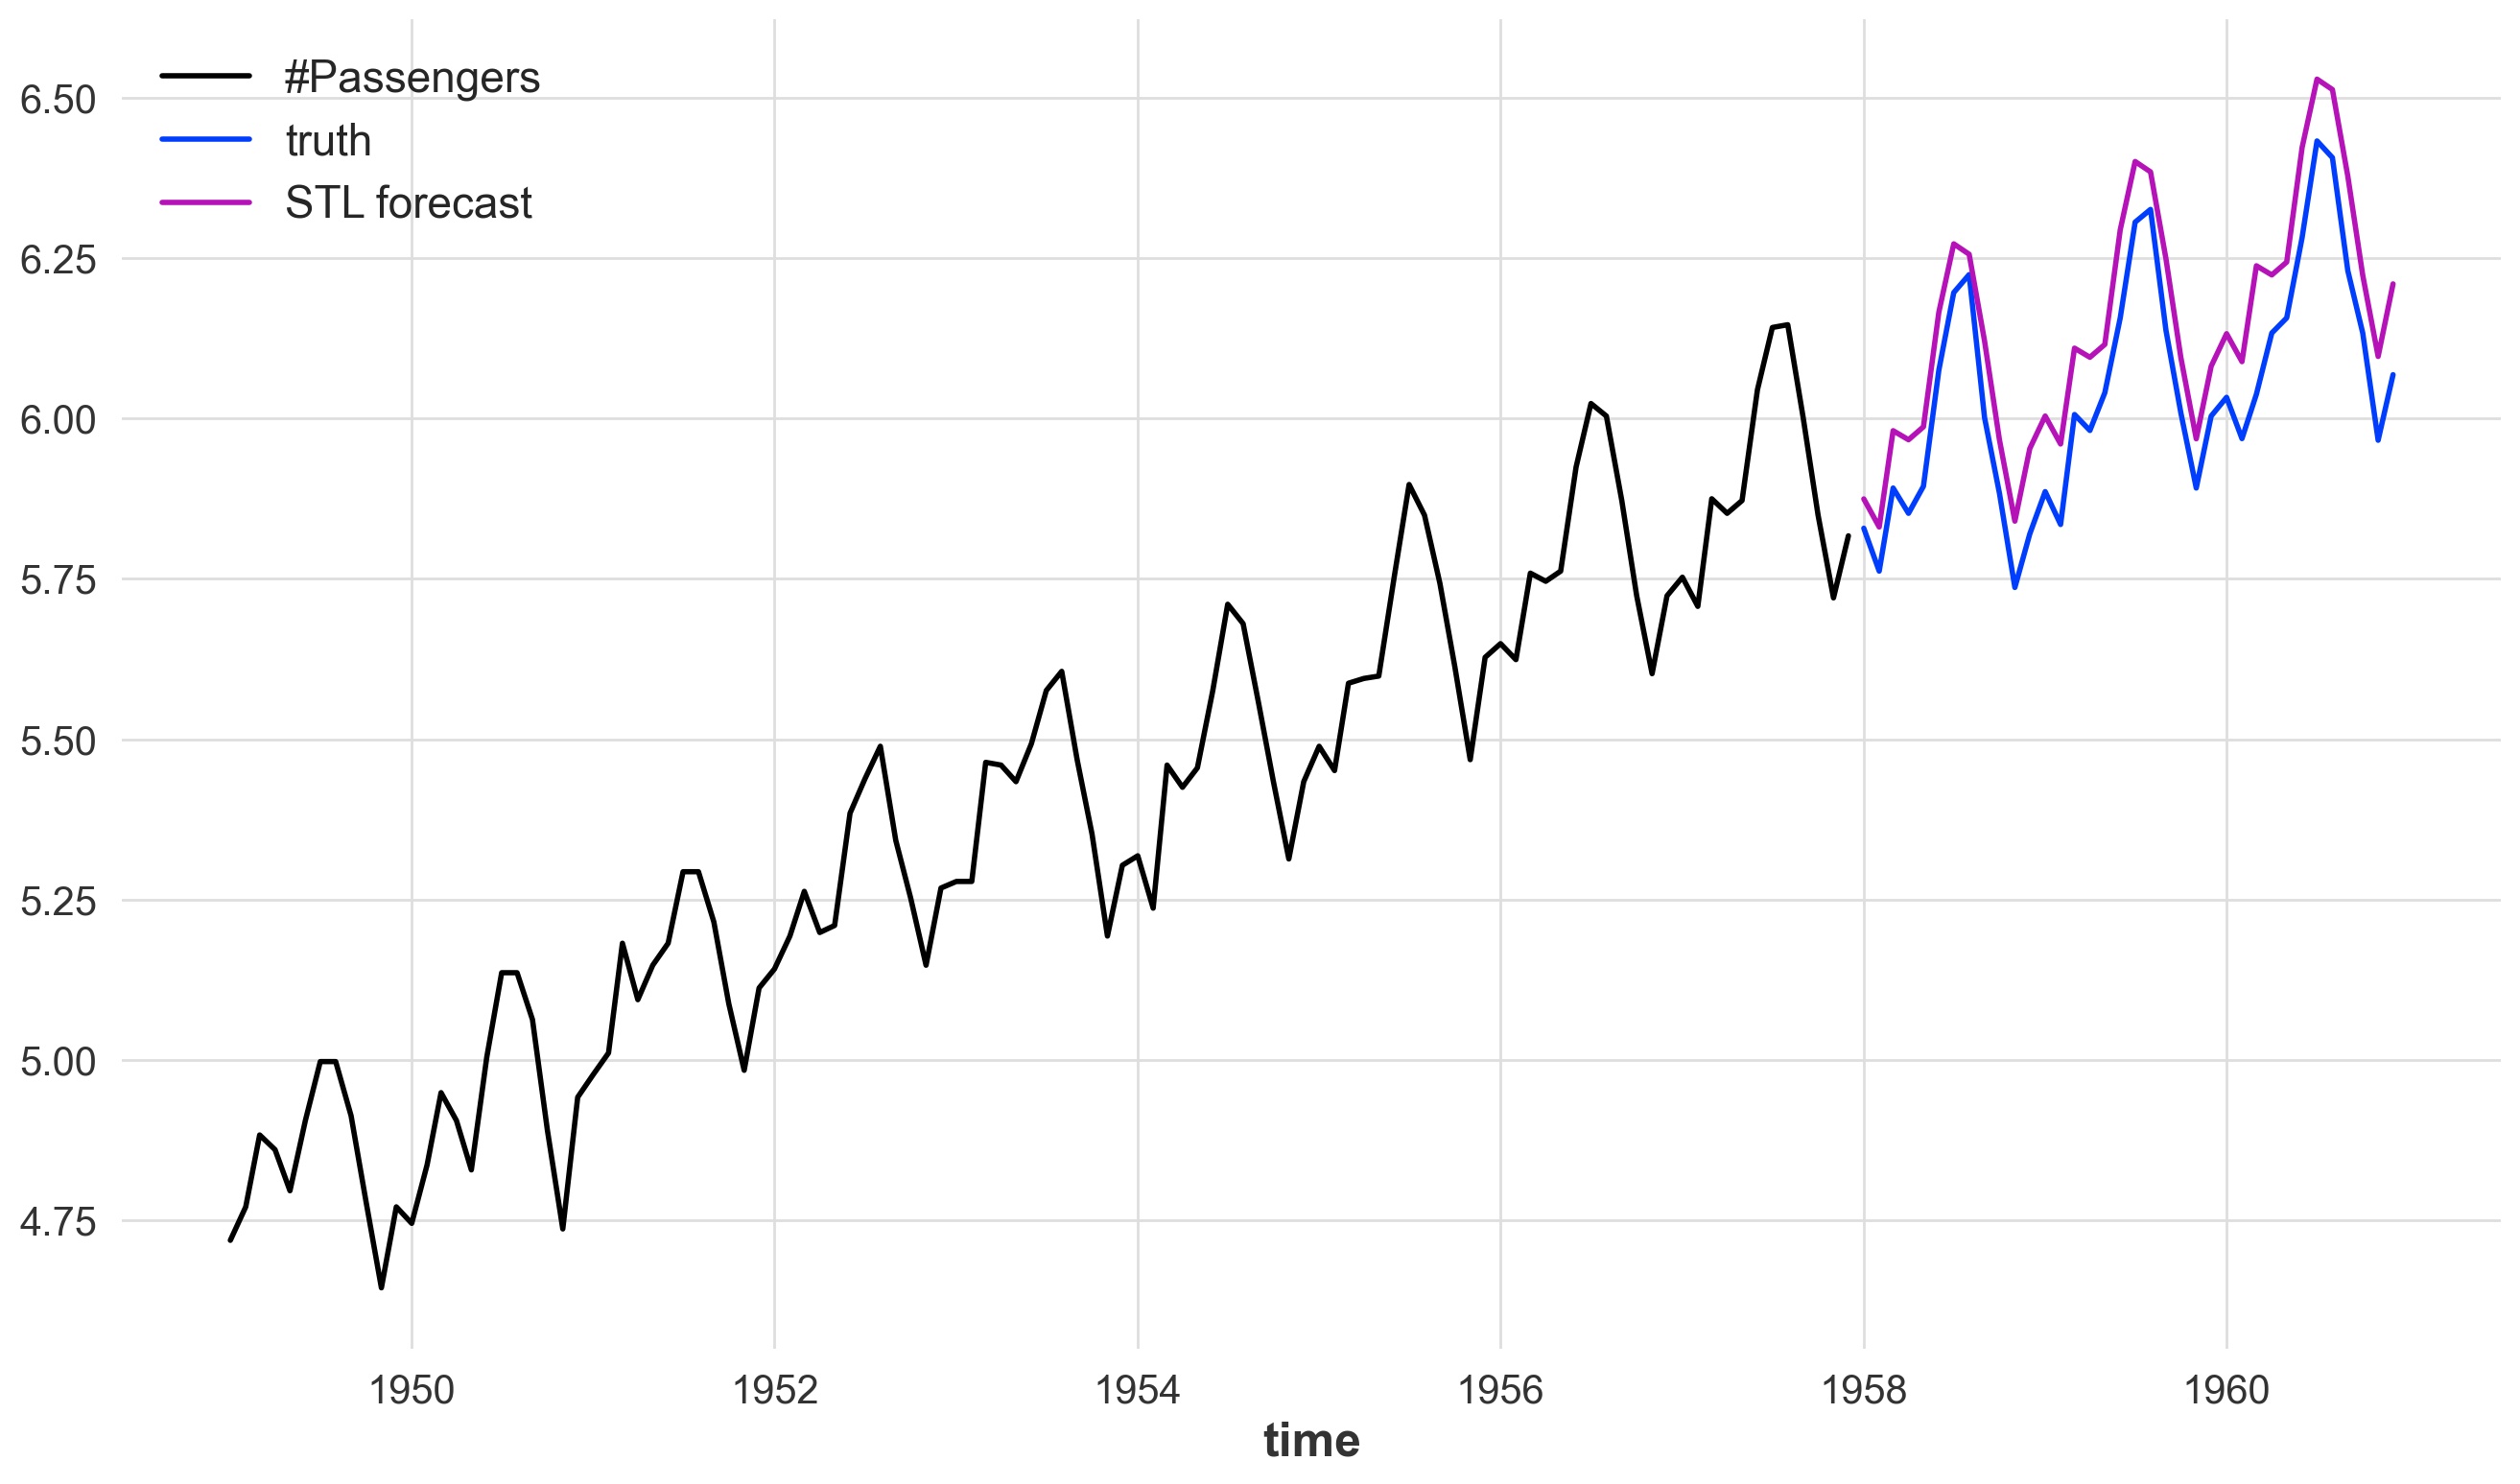

In [60]:
fig, ax = plt.subplots(figsize=(16,9))
train.map(lambda ts, x: np.log(x)).plot(ax=ax);
val.map(lambda ts, x: np.log(x)).plot(label="truth", ax=ax);
fcast.plot(label="STL forecast", ax=ax);

## Quality measures

- MSE
  $$
  MSE=\frac{1}{T-R+1} \sum_{t=R}^T\left(\hat{x}_t-x_t\right)^2
  $$
- MAE
  $$
  MAE=\frac{1}{T-R+1} \sum_{t=R}^T\left|\hat{x}_t-x_t\right|.
  $$
- MAPE
  $$
  MAPE=\frac{100}{T-R+1} \sum_{t=R}^T\left|\frac{\hat{x}_t-x_t}{x_t}\right|.
  $$
- SMAPE
  $$
  SMAPE=\frac{200}{T-R+1} \sum_{t=R}^T\left|\frac{\hat{x}_t-x_t}{\hat{x}_t+x_t}\right|.
  $$
- MASE
  $$
  MASE=\frac{1}{T-R+1} \sum_{t=R}^T\left|\hat{x}_t-x_t\right| \big/ \frac{1}{T-1} \sum_{t=2}^T\left|x_t-x_{t-1}\right|.
  $$

## AutoETS

In [61]:
from darts.models import StatsForecastAutoETS

In [62]:
auto_ets = StatsForecastAutoETS(season_length=12)
auto_ets.fit(train)

StatsForecastAutoETS(add_encoders=None, season_length=12)

In [63]:
auto_fcast = auto_ets.predict(len(val))

In [64]:
auto_ets.model.model_["method"]

'ETS(M,N,M)'

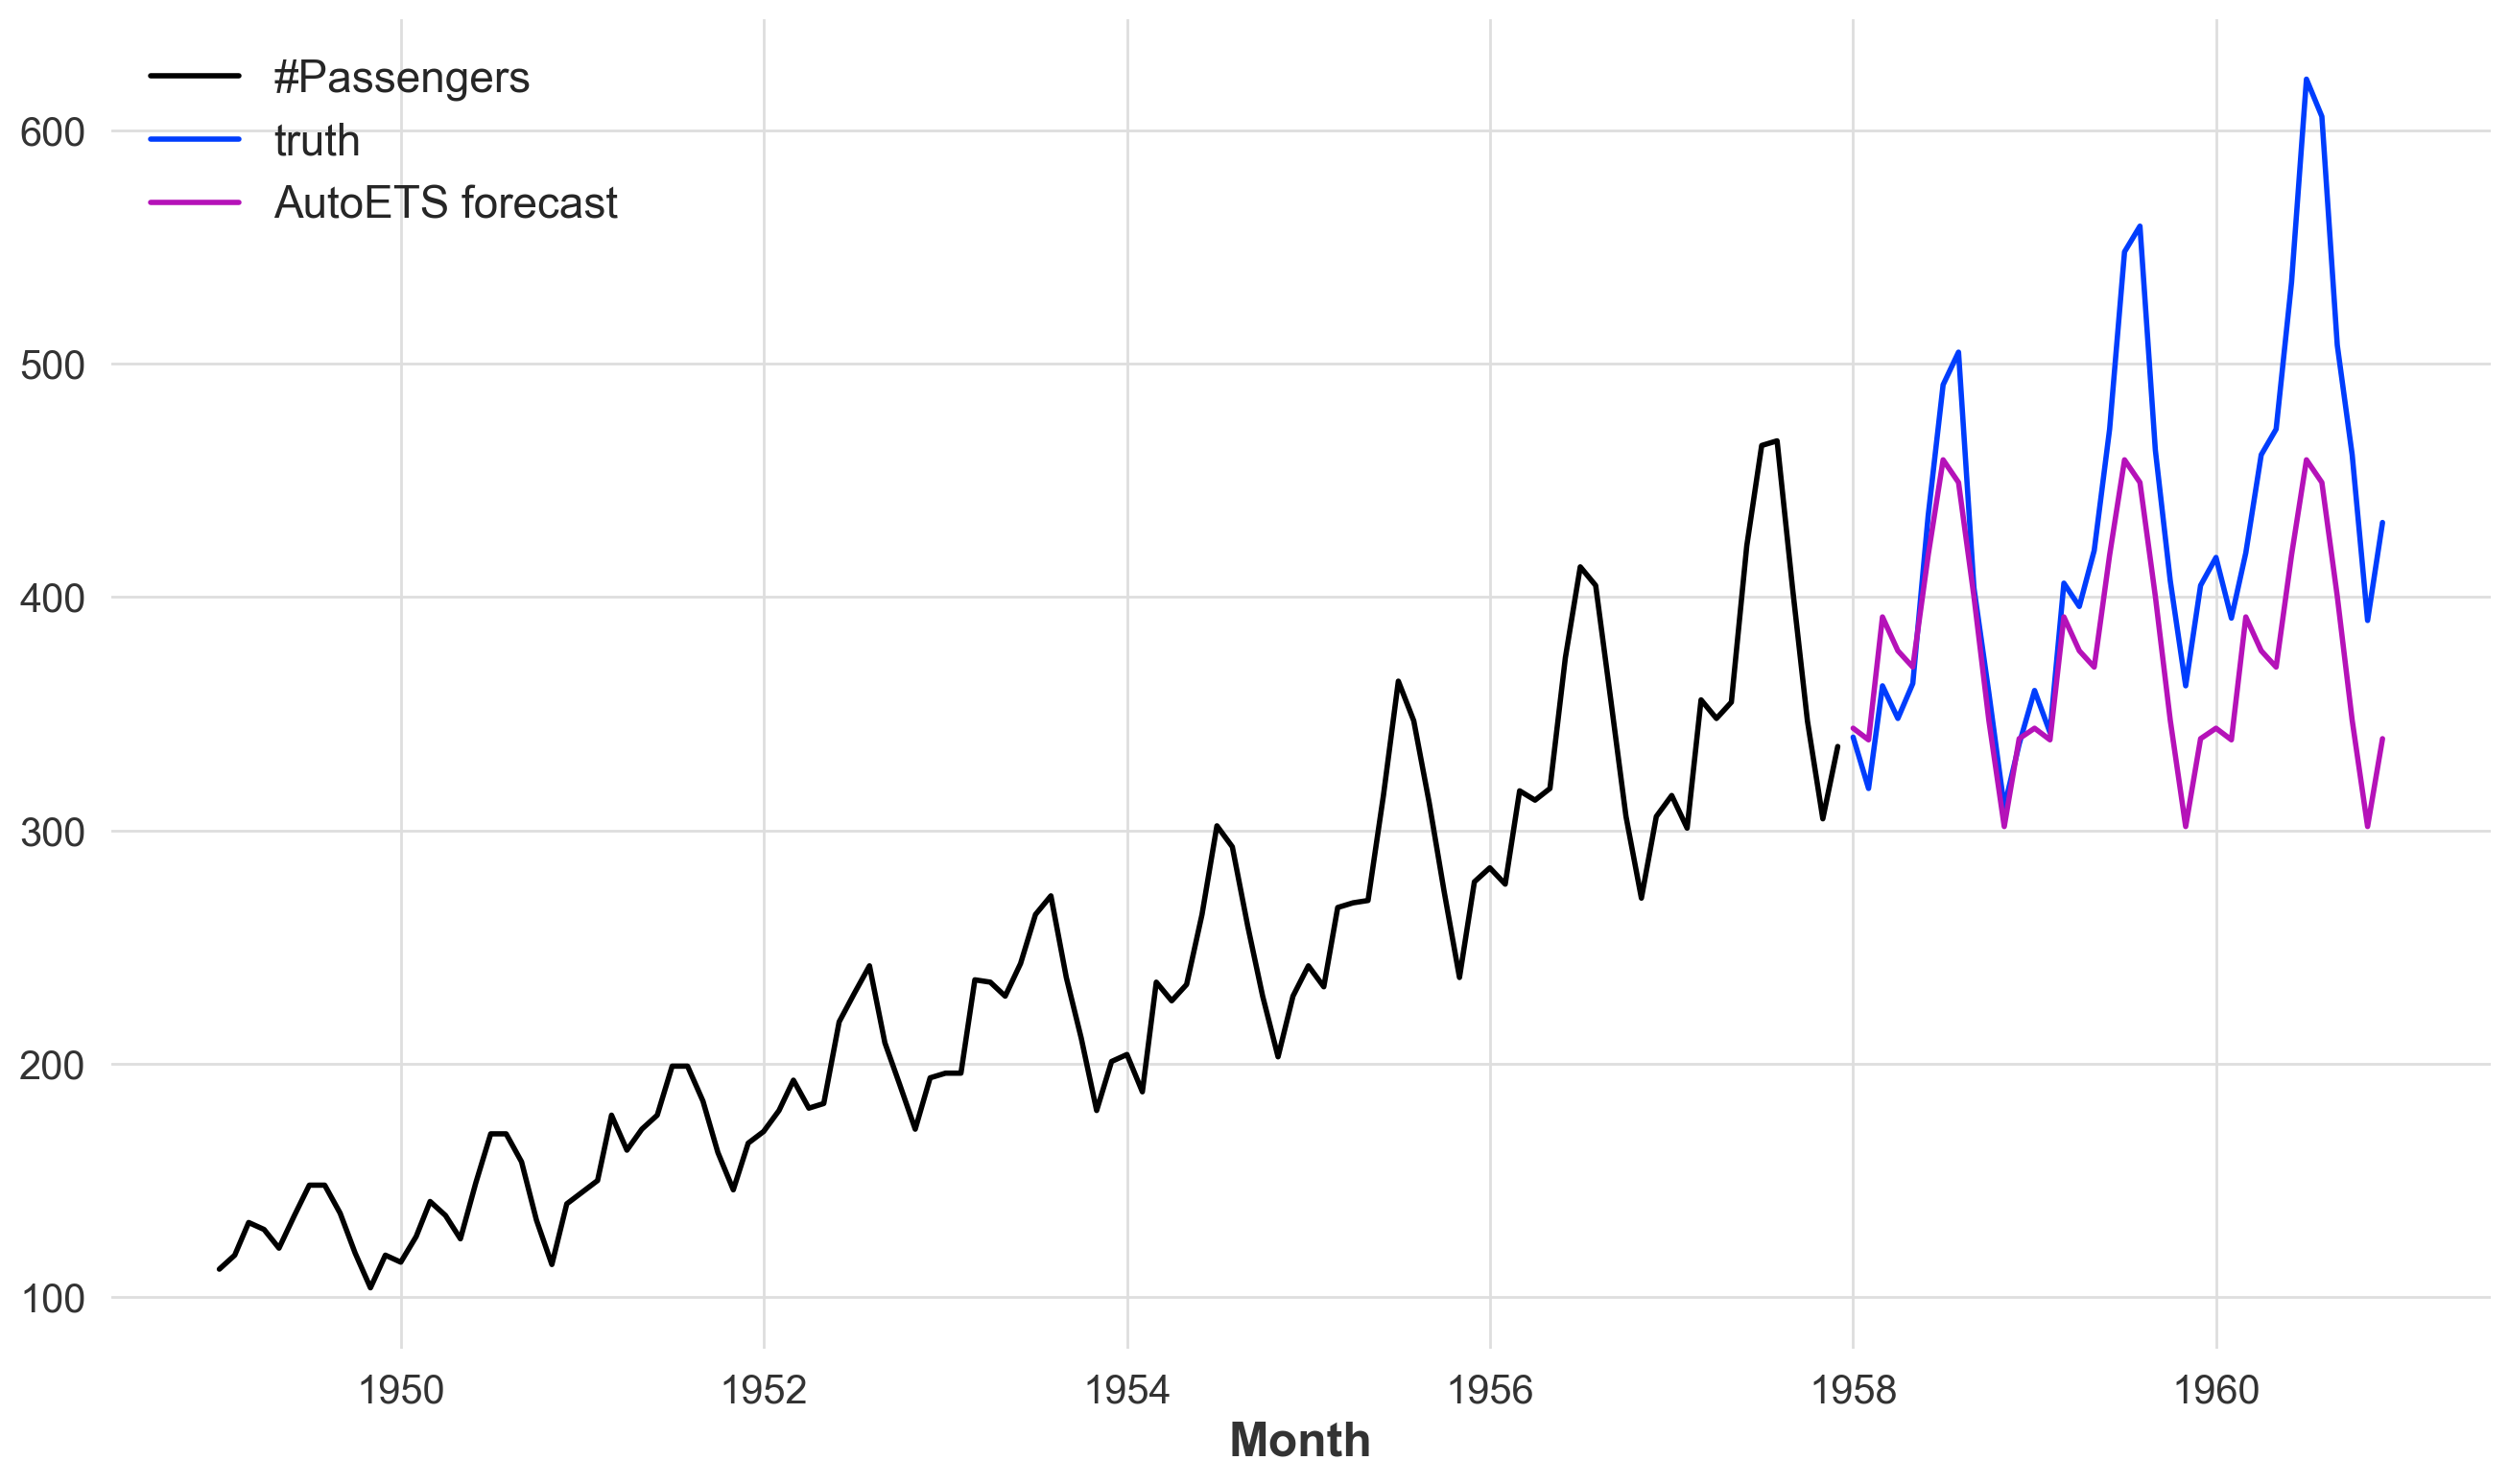

In [65]:
fig, ax = plt.subplots(figsize=(16,9))
train.plot(ax=ax);
val.plot(label="truth", ax=ax);
auto_fcast.plot(label="AutoETS forecast", ax=ax);